# AT1 - Australian Skills Classification (ASC) Text Analysis

## Project Overview

The Australian Government employs the use of the Australian Skills Classification (ASC) to consolidate the core competencies, specialist tasks and technology tools required for the country's occupations. Through the ASC, a common language of skills are made accessible, enabling any stakeholder to be able to identify and articulate the skills using a universal and comprehensive taxonomy.

This project aims to assess whether the current ASC satisfies its objectives using Natural Language Processing (NLP) Techniques.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

file_path = "/content/drive/My Drive/NLP/AT1/Australian Skills Classification - December 2023.xlsx"

In [3]:
!pip install pyldavis
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [4]:
#processing of tokens
import nltk

nltk.download('punkt_tab')
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
from nltk import bigrams
from nltk.stem import SnowballStemmer, WordNetLemmatizer

#text/data manipulation
import string
import re
import numpy as np

#text relationship
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage

#visualisation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from mpl_toolkits.axes_grid1 import make_axes_locatable

import requests
from bs4 import BeautifulSoup

from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
import spacy
from tqdm import tqdm
from gensim.models.ldamodel import LdaModel
import pyLDAvis
from pyLDAvis.gensim import prepare
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as mcolors

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from umap import UMAP

import random
import os
import glob


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
for var in [var for var in globals() if isinstance(globals()[var], pd.DataFrame)]:
    del globals()[var]

In [6]:
# Load Excel file
file_path = "/content/drive/My Drive/NLP/AT1/Australian Skills Classification - December 2023.xlsx"  # Replace with your file path
xls = pd.ExcelFile(file_path)

# Loop through each sheet and create a DataFrame with the sheet name as the variable name
for sheet_name in xls.sheet_names:
    # Replace spaces and special characters in sheet names for valid variable names
    df_name = sheet_name.strip().replace(" ", "_").replace("-", "_")
    globals()[df_name] = xls.parse(sheet_name)

In [7]:
# Get all variables in the global namespace
existing_dfs = [var for var in globals() if isinstance(globals()[var], pd.DataFrame)]

# Print the list of DataFrame names
print("Existing DataFrames:", existing_dfs)

Existing DataFrames: ['Index', 'Glossary', 'Occupation_descriptions', 'Core_competency_descriptions', 'Specialist_tasks_hierarchy', 'Tech_tools_heirarchy', 'Core_competencies', 'Specialist_tasks_data', 'Technology_tools', 'Appendix___tech_tool_examples', 'Appendix___common_tech_tools']


In [8]:
df_analysis = ['Occupation_descriptions', 'Core_competency_descriptions', 'Specialist_tasks_hierarchy', 'Tech_tools_heirarchy', 'Core_competencies', 'Specialist_tasks_data', 'Technology_tools']

In [9]:
for df_name in df_analysis:
    print(f"\n--- DataFrame: {df_name} ---")
    print(globals()[df_name].info())  # Print .info() for each DataFrame


--- DataFrame: Occupation_descriptions ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Occupation Type     1650 non-null   object
 1   ANZSCO Code         1650 non-null   int64 
 2   Sub-Profile Code    472 non-null    object
 3   ANZSCO Title        1650 non-null   object
 4   ANZSCO Description  1650 non-null   object
dtypes: int64(1), object(4)
memory usage: 64.6+ KB
None

--- DataFrame: Core_competency_descriptions ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Core Competency              100 non-null    object
 1   Core Competency Description  100 non-null    object
 2   Score                        100 non-null    int64 
 3   Proficiency Leve

In [10]:
for df_name in df_analysis:
    df = globals()[df_name]
    print(f"\n--- DataFrame: {df_name} ---")
    print(df.isna().sum())
    print(f"total number of rows: {df.count().max()}")


--- DataFrame: Occupation_descriptions ---
Occupation Type          0
ANZSCO Code              0
Sub-Profile Code      1178
ANZSCO Title             0
ANZSCO Description       0
dtype: int64
total number of rows: 1650

--- DataFrame: Core_competency_descriptions ---
Core Competency                0
Core Competency Description    0
Score                          0
Proficiency Level              0
Anchor Value                   0
dtype: int64
total number of rows: 100

--- DataFrame: Specialist_tasks_hierarchy ---
Specialist Task       0
Specialist Cluster    0
Cluster Family        0
Skill Statement       0
dtype: int64
total number of rows: 1686

--- DataFrame: Tech_tools_heirarchy ---
Technology Tool Category                0
Technology Tool Category Description    0
Technology Tool                         0
Technology Tool Description             0
Technology Tool Extended Description    0
dtype: int64
total number of rows: 94

--- DataFrame: Core_competencies ---
Occupation Type   

In [11]:
for df_name in df_analysis:
    df = globals()[df_name]  # Get the DataFrame from globals
    df[:] = df.astype(str)  # Convert all columns to string type

<ipython-input-11-077effc8f21d>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0         1111
1         1112
2         1211
3         1213
4         1215
         ...  
1645    899999
1646    899999
1647    899999
1648    899999
1649    899999
Name: ANZSCO Code, Length: 1650, dtype: object' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[:] = df.astype(str)  # Convert all columns to string type
<ipython-input-11-077effc8f21d>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      1
1      2
2      3
3      4
4      5
      ..
95     6
96     7
97     8
98     9
99    10
Name: Score, Length: 100, dtype: object' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[:] = df.astype(str)  # Convert all columns to string type
<ipython-input-11-077effc8f21d>:3: Future

In [12]:
Occupation_descriptions[['ANZSCO Title', 'ANZSCO Description']].describe()

,ANZSCO Title,ANZSCO Description
count,1650,1650
unique,1650,1650
top,Chief Executives and Managing Directors,Chief Executives and Managing Directors determ...
freq,1,1


In [13]:
Occupation_descriptions[['ANZSCO Title', 'ANZSCO Description']].sample(5)

,ANZSCO Title,ANZSCO Description
1159,Parole or Probation Officer,Supervises offenders who have been placed on p...
384,ICT Managers nec,This occupation group covers ICT Managers not ...
906,Economic Historian,Researches changes in economic circumstances o...
1363,Model,"Wears and displays clothing and accessories, a..."
626,Engineering Professionals nec,This occupation group covers Engineering Profe...


In [14]:
Core_competency_descriptions[['Core Competency', 'Core Competency Description']].describe()

,Core Competency,Core Competency Description
count,100,100
unique,10,10
top,Digital engagement,Identifying and using technology (including ha...
freq,10,10


In [15]:
Core_competency_descriptions[['Core Competency', 'Core Competency Description']].sample(5)

,Core Competency,Core Competency Description
50,Planning and organising,Developing specific goals and plans to priorit...
35,Numeracy,Using mathematics to solve problems and interp...
94,Writing,Communicating effectively in writing in a way ...
6,Digital engagement,Identifying and using technology (including ha...
43,Oral communication,The ability to communicate information and ide...


In [16]:
Specialist_tasks_hierarchy.describe()

,Specialist Task,Specialist Cluster,Cluster Family,Skill Statement
count,1686,1686,1686,1686
unique,1686,272,31,1686
top,Advise others on farming or forestry operation...,"Inspect, test or maintain equipment or systems",Health and care,Provide advice about managing farms and forest...
freq,1,25,150,1


In [17]:
Specialist_tasks_hierarchy.sample(5)

,Specialist Task,Specialist Cluster,Cluster Family,Skill Statement
684,Style clients' hair,Treat and groom hair,"Fashion, grooming, and cosmetics",Style or shape client’s hair to achieve a spec...
842,Implement advanced life support techniques,Provide health care or administer medical trea...,Health and care,Implement advanced life support techniques tha...
492,"Recommend products, goods, or services to cust...",Provide customer service and communicate infor...,Customer service,Provide support to customers by understanding ...
144,Coordinate flight control or management activi...,"Manage services, staff or activities",Business operations and financial activities,"Coordinate, schedule, or organise flight contr..."
458,Shape wet or dry concrete,Undertake masonry and earth laying,Construction,"Mould, shape, or form wet or dry concrete to m..."


In [18]:
Tech_tools_heirarchy.describe()

,Technology Tool Category,Technology Tool Category Description,Technology Tool,Technology Tool Description,Technology Tool Extended Description
count,94,94,94,94,94
unique,27,26,94,94,94
top,IT Infrastructure and management technologies,"Software, hardware, and other tools for the de...",Collaborative news production platforms,Software used to create and manage news conten...,Collaborative news production platforms encomp...
freq,11,11,1,1,1


In [19]:
tech_tools_category = Tech_tools_heirarchy[['Technology Tool Category', 'Technology Tool Category Description']].drop_duplicates()

# Display the DataFrame
tech_tools_category

,Technology Tool Category,Technology Tool Category Description
0,Broadcasting and audio-visual production techn...,"Systems for audio, video, multimedia and news ..."
4,Communication technologies,"Data, voice and/or video communication platforms"
7,Customer management and engagement platforms,Software that provides customer management and...
10,Data analysis and reporting platforms,Software for data analysis and produce electro...
14,Digital health records and patient management ...,Systems for managing health records and medica...
15,Education and student management platforms,Systems for managing student records and educa...
17,Financial management and service delivery plat...,Systems to undertake financial management and ...
20,Geographical guidance and navigation technologies,"Systems for real-time navigation, mapping and ..."
26,Graphic design and imagery technologies,Software for graphic design and photographic e...
30,Graphical modelling and technical design techn...,"Software for computer aided design, 3D modelli..."


In [20]:
Tech_tools_heirarchy.sample(5)

,Technology Tool Category,Technology Tool Category Description,Technology Tool,Technology Tool Description,Technology Tool Extended Description
22,Geographical guidance and navigation technologies,"Systems for real-time navigation, mapping and ...",Aviation and marine communication systems,Radio and communications apparatus that enable...,Aviation and marine communication systems enco...
31,Graphical modelling and technical design techn...,"Software for computer aided design, 3D modelli...",Motion analysis software,Software that uses video footage to analyse th...,Motion Analysis Software encompasses software ...
3,Broadcasting and audio-visual production techn...,"Systems for audio, video, multimedia and news ...",Video creation and editing software,Software used to create and edit digital video...,Video creation and editing software enables th...
92,Web development and content management platforms,Software platforms for developing web pages an...,Social media platforms,Software or website used to publish and share ...,Social media platforms encompasses the broad s...
4,Communication technologies,"Data, voice and/or video communication platforms",Audio/video conferencing software,Software for collaboration using video or audi...,Audio/video conferencing software enables peop...


Exploration of Occupation Description

In [21]:
def word_count(text):
    wc = len(text.split())
    return wc

In [22]:
Occupation_descriptions['desc_word_count'] = Occupation_descriptions['ANZSCO Description'].apply(word_count)
Occupation_descriptions['title_word_count'] = Occupation_descriptions['ANZSCO Title'].apply(word_count)

In [23]:
Occupation_descriptions[['title_word_count', 'desc_word_count']].describe()

,title_word_count,desc_word_count
count,1650.000000,1650.000000
mean,2.767879,27.976364
std,1.364031,20.053114
min,1.000000,4.000000
25%,2.000000,15.000000
50%,2.000000,22.000000
75%,3.000000,32.000000
max,10.000000,119.000000


In [24]:
Occupation_descriptions[['title_word_count', 'desc_word_count']].sum()

,0
title_word_count,4567
desc_word_count,46161


array([[<Axes: title={'center': 'title_word_count'}>]], dtype=object)

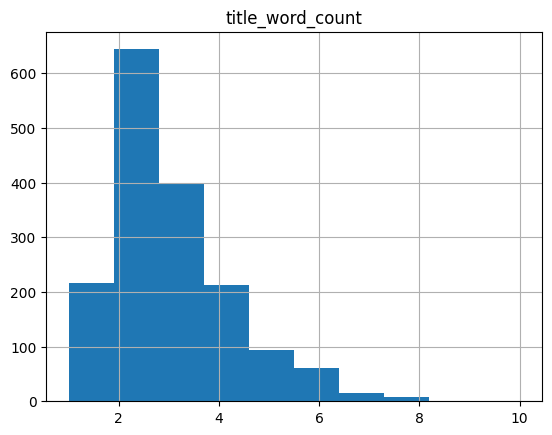

In [25]:
Occupation_descriptions[['title_word_count']].hist(bins = 10)

<Axes: >

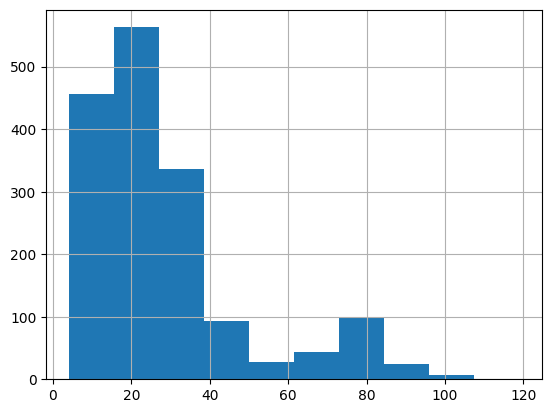

In [26]:
Occupation_descriptions['desc_word_count'].hist(bins = 10)

<ipython-input-27-725faadd1246>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "Occupation Type",


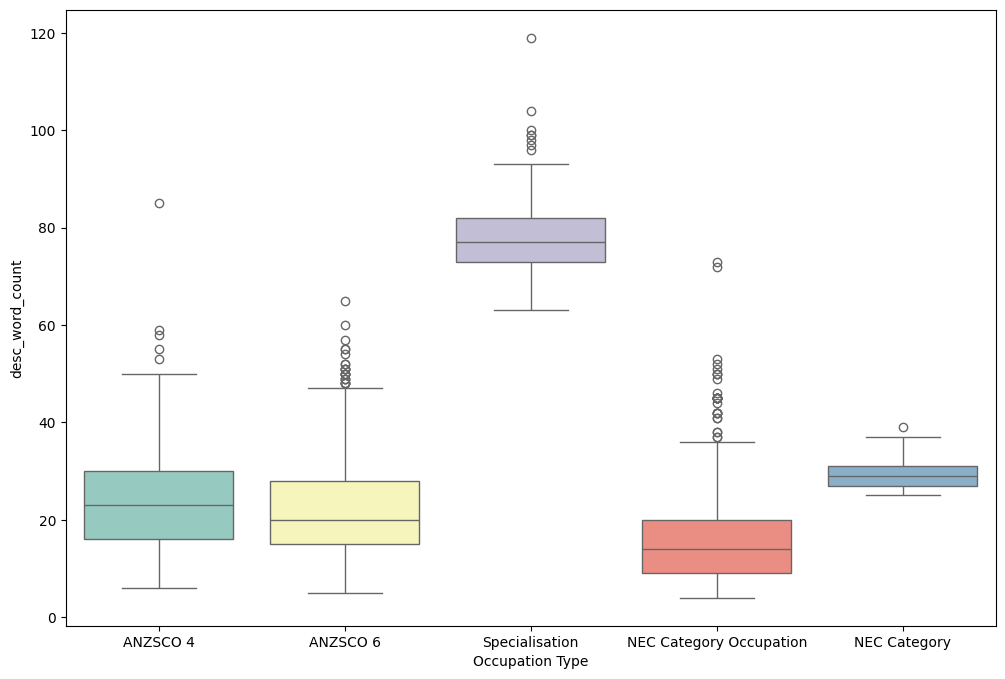

In [27]:
# Set the figure size
plt.figure(figsize=(12, 8))  # Adjust the size as needed

sns.boxplot(x = "Occupation Type",
            y = "desc_word_count",
            palette='Set3',
            data =Occupation_descriptions);

In [28]:
def wordBarGraphFunction(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

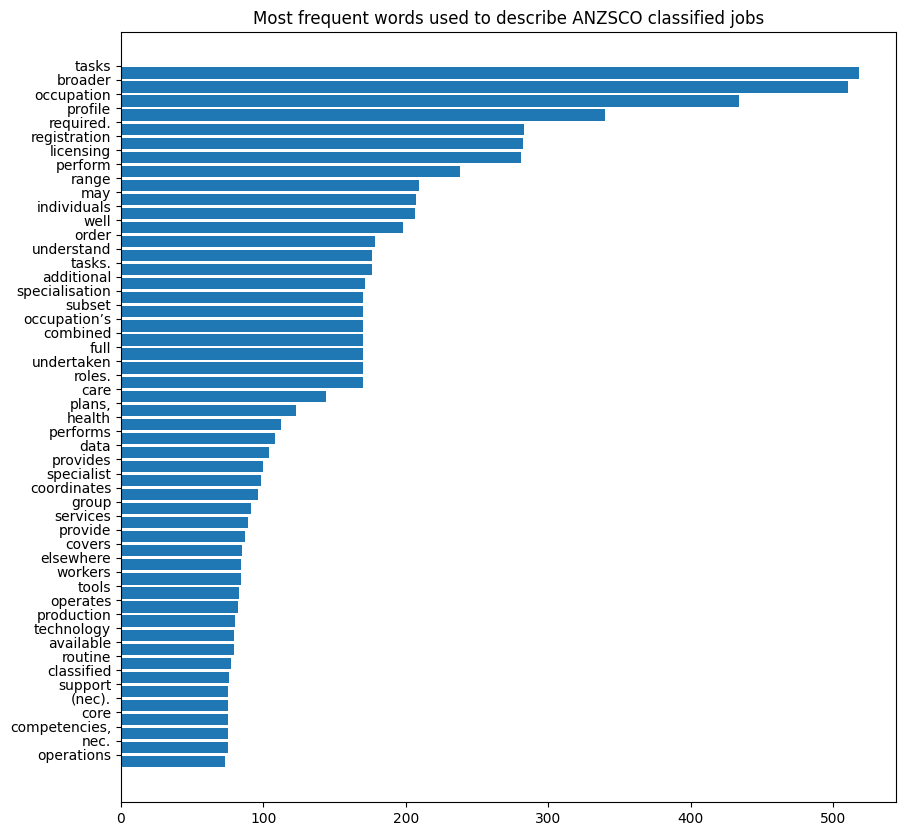

In [29]:
plt.figure(figsize=(10,10))
wordBarGraphFunction(Occupation_descriptions,'ANZSCO Description',"Most frequent words used to describe ANZSCO classified jobs")

In [30]:
OD_ANZSCODescription = Occupation_descriptions['ANZSCO Description'].to_string()
OD_ANZSCOtitle = Occupation_descriptions['ANZSCO Title'].to_string()

In [31]:
occ_title_token = word_tokenize(OD_ANZSCOtitle)
occ_desc_token = word_tokenize(OD_ANZSCODescription)

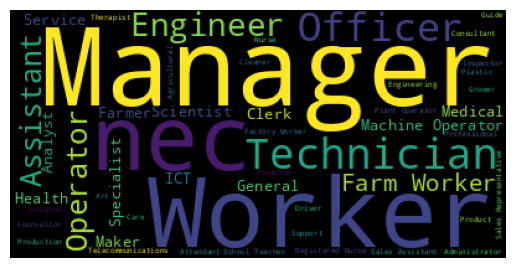

In [32]:
wordcloud = WordCloud(max_words=50).generate(OD_ANZSCOtitle)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

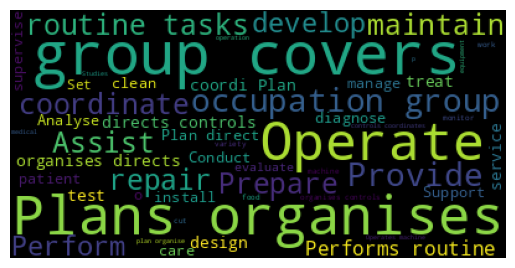

In [33]:
wordcloud = WordCloud(max_words=50).generate(OD_ANZSCODescription)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [34]:
def get_top_ngrams(text, n, top_k):

    # Generate n-grams
    n_grams = list(ngrams(text, n))

    # Count the frequency of each n-gram
    n_gram_freq = Counter(n_grams)

    # Get the top k most frequent n-grams
    top_n_grams = n_gram_freq.most_common(top_k)

    return top_n_grams

In [35]:
# Get top 5 bigrams
top_bigrams_title = get_top_ngrams(occ_title_token, 2, 5)

print("Top 5 Bigrams: Title")
for bigram, count in top_bigrams_title:
    print(f"{bigram}: {count}")

Top 5 Bigrams: Title
('Farm', 'Worker'): 25
('Machine', 'Operator'): 23
('(', 'General'): 19
('General', ')'): 18
('Registered', 'Nurse'): 18


In [36]:
# Get top 5 bigrams
top_bigrams = get_top_ngrams(occ_desc_token, 2, 5)

# Get top 5 trigrams
top_trigrams = get_top_ngrams(occ_desc_token, 3, 5)

# Print results
print("Top 5 Bigrams: Desc")
for bigram, count in top_bigrams:
    print(f"{bigram}: {count}")

print("\nTop 5 Trigrams: Desc")
for trigram, count in top_trigrams:
    print(f"{trigram}: {count}")

Top 5 Bigrams: Desc
('Plans', ','): 114
('group', 'covers'): 84
(',', 'organises'): 82
('This', 'occupation'): 76
('occupation', 'group'): 75

Top 5 Trigrams: Desc
('Plans', ',', 'organises'): 79
('This', 'occupation', 'group'): 75
('occupation', 'group', 'covers'): 75
(',', 'organises', ','): 70
('organises', ',', 'directs'): 47


In [37]:
class TextPreprocessor:
    def __init__(self, custom_punctuation=None, custom_stopwords=None):
        self.punctuation = string.punctuation
        if custom_punctuation:
            self.punctuation += custom_punctuation

        self.stop_words = set(stopwords.words('english'))
        if custom_stopwords:
            self.stop_words.update(custom_stopwords)

        self.stemmer = SnowballStemmer("english")
        self.lemmatizer = WordNetLemmatizer()

    def remove_punctuation(self, text):
        return re.sub(rf"[{re.escape(self.punctuation)}]", " ", text)

    def add_space_after_parenthesis(self, text):
        return re.sub(r'\)', ') ', text)

    def to_lowercase(self, text):
        return text.lower()

    def remove_stopwords(self, text):
        words = word_tokenize(text)
        return ' '.join([word for word in words if word not in self.stop_words])

    def remove_extra_whitespace(self, text):  # This is to remove extra spaces
        return re.sub(r'\s+', ' ', text).strip()

    def preprocess(self, text):
        text = self.add_space_after_parenthesis(text)
        text = self.remove_punctuation(text)
        text = self.to_lowercase(text)
        text = self.remove_stopwords(text)
        text = self.remove_extra_whitespace(text)
        return text

    def stem_words(self, text):
        words = self.preprocess(text)
        return ' '.join([self.stemmer.stem(word) for word in words])

    def lemmatize_words(self, text):
        words = self.preprocess(text)
        return ' '.join([self.lemmatizer.lemmatize(word) for word in words])

In [38]:
# Initiate Text Processor
preprocessor = TextPreprocessor()

# Preprocess the text
OD_title = preprocessor.preprocess(OD_ANZSCOtitle)
OD_title_token = word_tokenize(OD_title)

top_bigrams_title1 = get_top_ngrams(OD_title_token, 2, 10)

print("Top 10 Bigrams: Title")
for bigram, count in top_bigrams_title1:
    print(f"{bigram}: {count}")

Top 10 Bigrams: Title
('farm', 'worker'): 25
('machine', 'operator'): 23
('registered', 'nurse'): 18
('workers', 'nec'): 13
('plant', 'operator'): 11
('professionals', 'nec'): 10
('sales', 'representative'): 9
('factory', 'worker'): 9
('production', 'machine'): 8
('private', 'tuition'): 8


In [39]:
# Preprocess the text
OD_desc = preprocessor.preprocess(OD_ANZSCODescription)
OD_desc_token = word_tokenize(OD_desc)

top_bigrams_desc1 = get_top_ngrams(OD_desc_token, 2, 10)
top_trigrams_desc1 = get_top_ngrams(OD_desc_token, 3, 10)

print("Top 10 Bigrams: Desc")
for bigram, count in top_bigrams_desc1:
    print(f"{bigram}: {count}")
print()
print("Top 10 Trigrams: Desc")
for trigram, count in top_trigrams_desc1:
    print(f"{trigram}: {count}")

Top 10 Bigrams: Desc
('group', 'covers'): 84
('plans', 'organises'): 82
('occupation', 'group'): 75
('routine', 'tasks'): 59
('performs', 'routine'): 48
('organises', 'directs'): 47
('directs', 'controls'): 47
('controls', 'coordi'): 42
('organises', 'controls'): 36
('plan', 'direct'): 32

Top 10 Trigrams: Desc
('occupation', 'group', 'covers'): 75
('plans', 'organises', 'directs'): 47
('organises', 'directs', 'controls'): 47
('performs', 'routine', 'tasks'): 46
('directs', 'controls', 'coordi'): 42
('plan', 'direct', 'coordinate'): 30
('plans', 'organises', 'controls'): 23
('organises', 'controls', 'coordinates'): 23
('controls', 'coordinates', 'pe'): 20
('provides', 'nursing', 'care'): 15


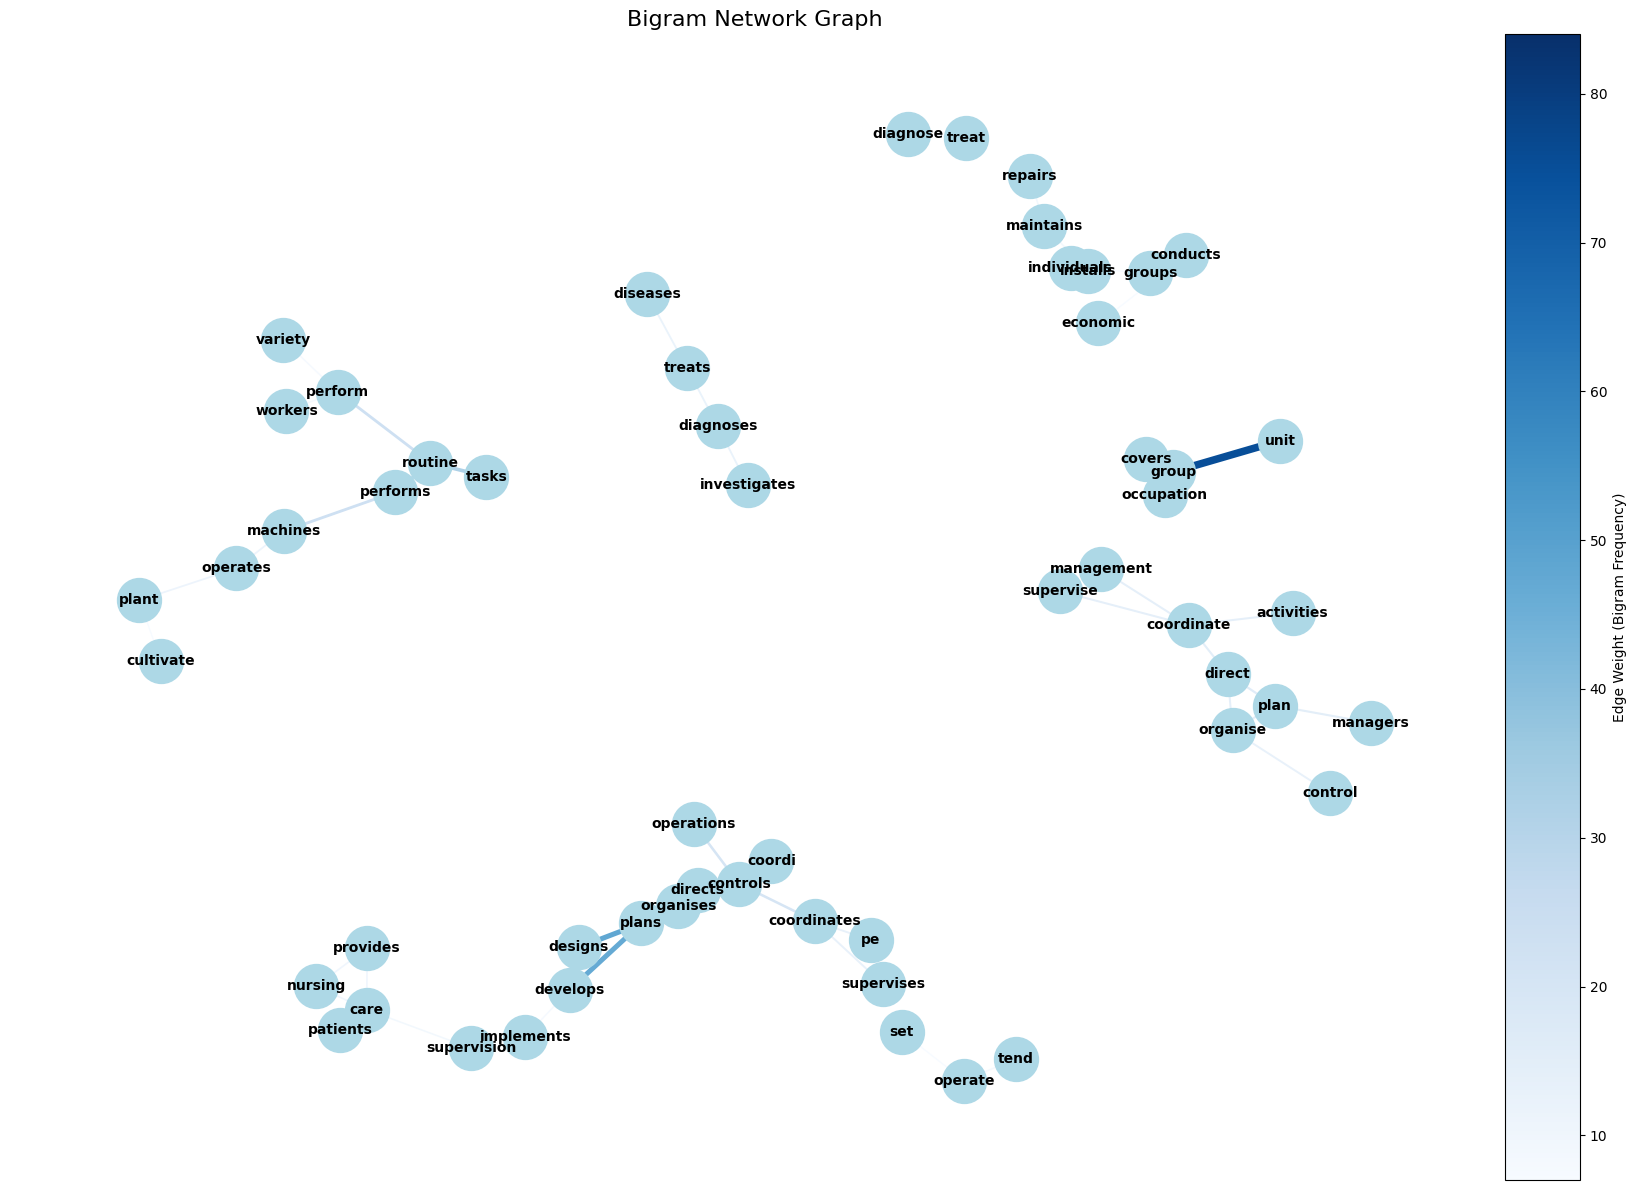

In [40]:
#n=50 limits the number of bigrams to display
def plot_bigram_network(tokens, n=50):
    # Get bigrams
    bi_grams = list(bigrams(tokens))

    # Count bigram frequencies
    bigram_freq = Counter(bi_grams)

    # Create network graph
    G = nx.Graph() # Create an empty undirected graph

    # Initialize empty lists to store edge widths and colors
    edge_width = []
    edge_color = []
    for bigram, count in bigram_freq.most_common(n):
        G.add_edge(bigram[0], bigram[1], weight=count)
        edge_width.append(count)
        edge_color.append(count)

    # Normalize edge widths for better visualization
    edge_width = np.array(edge_width)
    edge_width = 1 + (edge_width - edge_width.min()) * 5 / (edge_width.max() - edge_width.min()) #This normalizes the edge widths to a range between 1 and 6, making the differences in frequency visually apparent

    # Plot
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, k=0.5, iterations=50) #Compute the position of nodes using the spring layout algorithm

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=edge_width, edge_color=edge_color, edge_cmap=plt.cm.Blues)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

    # Set the title, remove the axis, and adjust the layout
    plt.title('Bigram Network Graph', fontsize=16)
    plt.axis('off')
    plt.tight_layout()

    # Add a colorbar to show the weight scale
    divider = make_axes_locatable(plt.gca())  # Create a divider for the current axis
    cax = divider.append_axes("right", size="5%", pad=0.05) # Append axes for the colorbar next to the main plot
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(edge_color), vmax=max(edge_color))) # Create a scalar mappable for the colorbar
    sm.set_array([]) # Set the array for the scalar mappable
    cbar = plt.colorbar(sm, cax=cax) # Create the colorbar
    cbar.set_label('Edge Weight (Bigram Frequency)', fontsize=10) # Set the label for the colorbar
    plt.show()

# Input is our list of tokenized words
plot_bigram_network(OD_desc_token)

In [41]:
def tokenize(text):
    # Apply the simple_preprocess function
    text = simple_preprocess(str(text), deacc=True)
    return text

OD_desc_token1 = Occupation_descriptions["ANZSCO Description"].apply(tokenize)

bigram = Phrases(OD_desc_token1, min_count=3, threshold=100)
bigram_model = Phraser(bigram)

print("Sample bigrams:")
print(", ".join(list(bigram.export_phrases().keys())[:5]))

# Collect the trigrams
trigram = Phrases(bigram[OD_desc_token1], threshold=100)
trigram_model = Phraser(trigram)

print("Sample trigrams:")
print(", ".join(list(trigram.export_phrases().keys())[:5]))

Sample bigrams:
plan_organise, organise_direct, major_functions, farming_operations, aquatic_stock
Sample trigrams:
plan_organise, managers_plan_organise, plan_organise_direct, direct_control, farming_operations


In [42]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
stop_words = stopwords.words('english')


# Function to remove stopwords
def remove_stopword(text):
    tokens = []
    for token in text:
        if token not in stop_words:
            # If the token is not in the list of stopwords
            # then keep it, else discard it
            tokens.append(token)
    return tokens

# Function to lemmatize the tokens
def lemmatize(tokens, allowed_postags=["NOUN", "ADJ", "VERB"]):
    text = " ".join(tokens)
    text = nlp(text)
    lemmatized_tokens = []

    for token in text:
        if token.pos_ in allowed_postags:
            lemmatized_tokens.append(token.lemma_)

    return lemmatized_tokens

# Function to create bigrams
def create_bigrams(text):
    return bigram_model[text]

# Function to create trigrams
def create_trigrams(text):
    return trigram_model[bigram_model[text]]

In [43]:
OD_desc_token1 = Occupation_descriptions["ANZSCO Description"].apply(tokenize)

tokenized_data = OD_desc_token1

# Apply function to remove the stopwords
tokenized_data_desc = [remove_stopword(text) for text in tokenized_data]

# Create the bigrams
bigram_data_desc = [create_bigrams(text) for text in tokenized_data_desc]

# Lemmatize the text
lemmatized_data_desc = [lemmatize(text) for text in bigram_data_desc]

In [44]:
tokenized_data_desc_str = [' '.join(tokens) for tokens in tokenized_data_desc]

# Vectorize the cleaned descriptions using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(tokenized_data_desc_str)

# Compute cosine similarity between rows
cos_sim_matrix = cosine_similarity(tfidf_matrix)

In [45]:
# Normalize function to handle singular and plural forms
def normalize_title(title):
    # Convert title to lowercase and remove "s" from the end (if it exists)
    normalized = title.lower().rstrip('s')
    return normalized

# Assuming you have a DataFrame called 'Occupation_descriptions'
titles = Occupation_descriptions['ANZSCO Title']

# Set to track the normalized titles
normalized_titles_set = set()
singular_plural_pairs = 0
singular_plural_titles = []


# Loop through all titles to count singular-plural pairs
for title in titles:
    normalized_title = normalize_title(title)

    # If the normalized title is already in the set, it's a singular-plural pair
    if normalized_title in normalized_titles_set:
        singular_plural_pairs += 1
        singular_plural_titles.append(title)
    else:
        # Add the normalized title to the set (whether singular or plural)
        normalized_titles_set.add(normalized_title)

# Calculate the total number of titles
total_titles = len(titles)

# Calculate the percentage of singular-plural pairs
percentage_singular_plural = (singular_plural_pairs / total_titles) * 100

# Print the results
print(f"Total Titles: {total_titles}")
print(f"Singular-Plural Pairs: {singular_plural_pairs}")
print(len(normalized_titles_set))
print(f"Percentage of Singular-Plural Pairs: {percentage_singular_plural:.2f}%")
print(singular_plural_titles)

Total Titles: 1650
Singular-Plural Pairs: 109
1541
Percentage of Singular-Plural Pairs: 6.61%
['Aquaculture Farmer', 'Corporate Services Manager', 'Finance Manager', 'Human Resource Manager', 'Policy and Planning Manager', 'Research and Development Manager', 'Engineering Manager', 'Manufacturer', 'Child Care Centre Manager', 'School Principal', 'Licensed Club Manager', 'Conference and Event Organiser', 'Photographer', 'Training and Development Professional', 'Economist', 'Librarian', 'Public Relations Professional', 'Interior Designer', 'Urban and Regional Planner', 'Electrical Engineer', 'Electronics Engineer', 'Veterinarian', 'Early Childhood (Pre-primary School) Teacher', 'Primary School Teacher', 'Secondary School Teacher', 'Occupational Therapist', 'Physiotherapist', 'Podiatrist', 'Anaesthetist', 'Psychiatrist', 'Nurse Manager', 'Barrister', 'Solicitor', 'Social Worker', 'Safety Inspector', 'Automotive Electrician', 'Sheetmetal Worker', 'Panelbeater', 'Vehicle Painter', 'Floor Fin

In [46]:
# Define a threshold for similarity
threshold = 0.8

# Assuming you have a DataFrame called 'df' and a cosine similarity matrix 'cos_sim_matrix'
# Get the indices of the highly similar pairs
similar_pairs = np.where(cos_sim_matrix > threshold)

# Create a dictionary to store the count of high similarity and similar titles for each 'ANZSCO Title'
similarity_count = {}
similar_titles = {}

# Loop through the pairs and count the similarities
for i, j in zip(*similar_pairs):
    if i != j:  # Avoid comparing the row with itself
        title_i = Occupation_descriptions['ANZSCO Title'].iloc[i]
        title_j = Occupation_descriptions['ANZSCO Title'].iloc[j]

        # Update the count for each ANZSCO Title pair
        similarity_count[title_i] = similarity_count.get(title_i, 0) + 1
        similarity_count[title_j] = similarity_count.get(title_j, 0) + 1

        # Track the similar titles for each 'ANZSCO Title'
        if title_i not in similar_titles:
            similar_titles[title_i] = []
        if title_j not in similar_titles:
            similar_titles[title_j] = []

        similar_titles[title_i].append(title_j)
        similar_titles[title_j].append(title_i)

# Sort the titles based on the number of similarities (highest first)
sorted_titles = sorted(similarity_count.items(), key=lambda x: x[1], reverse=True)

# Set to keep track of processed titles to avoid repeating them
processed_titles = set()
title_isolated = []


# Print the top titles with high similarity, ensuring no repeats
print("Top ANZSCO Titles with high similarity:")

for title, count in sorted_titles:
    if title in processed_titles:
        continue  # Skip if this title has already been processed

    # Print the title and its similarity count
    print(f"\nTitle: {title} - Similarity Count: {count}")
    title_isolated.append(title)

    # Get the similar titles, removing duplicates using a set
    similar_titles_set = set(similar_titles[title])

    # Print all similar titles for the current title
    print(f"Similar Titles: {', '.join(similar_titles_set)}")

    # Add this title and its similar titles to the processed set to avoid repeating them
    processed_titles.add(title)
    processed_titles.update(similar_titles_set)

Top ANZSCO Titles with high similarity:

Title: Coffee Grower - Similarity Count: 18
Similar Titles: Mushroom Grower, Tree Farmer, Emu Farmer, Ginger Farmer, Crocodile Farmer, Llama Farmer, Alpaca Farmer, Hop Farmer, Ostrich Farmer

Title: Engineering Surveyor - Similarity Count: 6
Similar Titles: Photogrammetric Surveyor, Mine Surveyor, Hydrographic Surveyor

Title: Music Teacher (Private Tuition) - Similarity Count: 6
Similar Titles: Art Teacher (Private Tuition), Dance Teacher (Private Tuition), Drama Teacher (Private Tuition)

Title: Clothing Sales Assistant - Similarity Count: 6
Similar Titles: Hardware Sales Assistant, Fast Food Sales Assistant, Cosmetic Sales Assistant

Title: Goat Herder - Similarity Count: 6
Similar Titles: Emu Farm Worker, Deer Farm Worker, Ostrich Farm Worker

Title: Middle School Teacher / Intermediate School Teacher - Similarity Count: 4
Similar Titles: Middle School Teachers / Intermediate School Teachers, Secondary School Teacher

Title: Specialist Manag

<ipython-input-47-16434e5ada6e>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Similarity Count', y='ANZSCO Title', data=df_similarity, palette=colors)


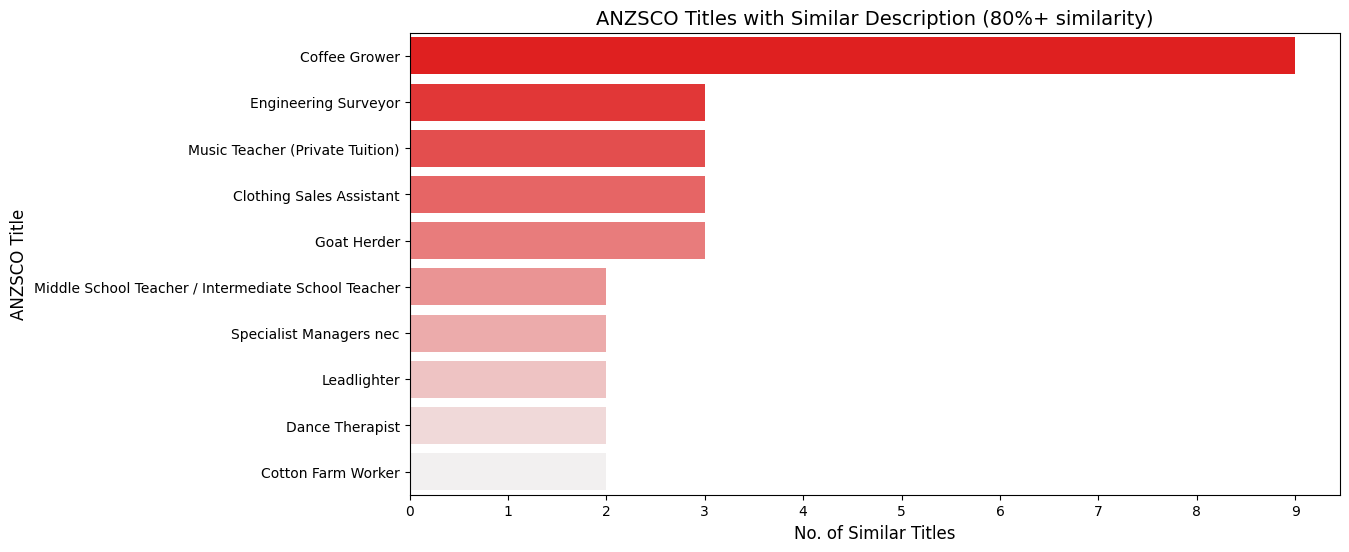

In [47]:
# Convert sorted titles list to DataFrame
df_similarity = pd.DataFrame(sorted_titles, columns=['ANZSCO Title', 'Similarity Count'])

# Filter to keep only the first occurrence of each processed title
df_similarity = df_similarity[df_similarity['ANZSCO Title'].isin(title_isolated)]

# Select the top 10 highest similarity counts
df_similarity = df_similarity.head(10)

# Divide 'Similarity Count' by 2 and ensure the result is an integer
df_similarity['Similarity Count'] = (df_similarity['Similarity Count'] / 2).astype(int)

# Create a red-to-light-red color palette
colors = sns.light_palette("red", reverse=True, n_colors=len(df_similarity))

# Plot horizontal bar chart with the custom red-to-light-red palette
plt.figure(figsize=(12, 6))
sns.barplot(x='Similarity Count', y='ANZSCO Title', data=df_similarity, palette=colors)

# Title and labels
plt.title('ANZSCO Titles with Similar Description (80%+ similarity)', fontsize=14)
plt.xlabel('No. of Similar Titles', fontsize=12)
plt.ylabel('ANZSCO Title', fontsize=12)

# Format x-axis to show integer values only
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Show the plot
plt.show()

In [48]:
def concatenate_by_group(df, group_col, concat_cols):
    """
    Concatenates values in concat_cols grouped by unique values in group_col.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        group_col (str): Column to group by.
        concat_cols (list): Columns whose values should be concatenated.

    Returns:
        pd.DataFrame: New DataFrame with grouped and concatenated values.
    """
    agg_dict = {col: ', '.join for col in concat_cols}
    return df.groupby(group_col, as_index=False).agg(agg_dict)

def concatenate_by_group_same_row(df, group_col, concat_cols):
    """
    Concatenates values in concat_cols grouped by unique values in group_col.
    First, it ensures concatenation within the same row before grouping.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        group_col (str): Column to group by.
        concat_cols (list): Columns whose values should be concatenated.

    Returns:
        pd.DataFrame: New DataFrame with grouped and concatenated values.
    """
    # Concatenate values within the same row first
    df['concatenated'] = df[concat_cols].apply(lambda x: ' '.join(x.astype(str)), axis=1)

    # Group by the specified column and keep only the concatenated column and group column
    grouped_df = df.groupby(group_col, as_index=False)['concatenated'].agg(', '.join)

    return grouped_df

In [49]:
concat_CC = concatenate_by_group(Core_competencies, 'ANZSCO Title', ['Anchor Value'])
concat_CC1 = concatenate_by_group_same_row(Core_competencies, 'ANZSCO Title', ['Proficiency Level', 'Core Competency'])
CC_comb = pd.merge(concat_CC1, concat_CC, on='ANZSCO Title', how='outer')
CC_comb.head(5)

,ANZSCO Title,concatenated,Anchor Value
0,Aboriginal and Torres Strait Islander Educatio...,"Intermediate Digital engagement, High Initiati...",Build and maintain an effective online profile...
1,Aboriginal and Torres Strait Islander Health W...,"Intermediate Digital engagement, High Initiati...",Use software on a portable device to document ...
2,Accountant (General),"Intermediate Digital engagement, High Initiati...",Write software for keeping track of items in a...
3,Accountants,"Intermediate Digital engagement, High Initiati...",Write software for keeping track of items in a...
4,Accounting Clerks,"Intermediate Digital engagement, Intermediate ...",Use software on a portable device to document ...


In [50]:
def custom_token(text_series):
    return [token for text in text_series for token in text.split(', ')]

In [51]:
def extract_phrase(text_series):
    """Extracts proficiency level + skill as a tokenized list from a column."""
    tokens = [phrase.strip() for text in text_series.dropna() for phrase in text.split(', ')]
    return tokens

# Tokenize the column
CC_competency_tokens = extract_phrase(CC_comb['concatenated'])

# Count occurrences
proficiency_counts = Counter(CC_competency_tokens)

# Get top 10 most common proficiency requirements
top_proficiency = proficiency_counts.most_common(10)
least_required_proficiency = proficiency_counts.most_common()[-10:]
least_required_proficiency.reverse()

# Print results
print("Top 10 Proficiency Requirements:")
for skill, count in top_proficiency:
    print(f"{skill}: {count}")
print()
print("10 Least Required Proficiencies:")
for skill, count in least_required_proficiency:
    print(f"{skill}: {count}")

Top 10 Proficiency Requirements:
Intermediate Problem solving: 1070
Intermediate Learning: 1060
Intermediate Oral communication: 1045
Intermediate Writing: 1029
Intermediate Reading: 962
Intermediate Numeracy: 945
Intermediate Digital engagement: 843
Intermediate Teamwork: 830
Intermediate Initiative and innovation: 655
Intermediate Planning and organising: 596

10 Least Required Proficiencies:
Basic Oral communication: 2
Basic Reading: 4
Basic Problem solving: 4
Basic Teamwork: 5
Basic Learning: 15
High Numeracy: 22
High Writing: 24
High Learning: 28
High Problem solving: 29
Basic Writing: 50


In [52]:
def concatenate_by_group_same_row_u(df, group_col, concat_cols):
    """
    Concatenates unique values in concat_cols grouped by unique values in group_col.
    First, it ensures concatenation within the same row before grouping,
    and only unique values from each row are concatenated.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        group_col (str): Column to group by.
        concat_cols (list): Columns whose values should be concatenated.

    Returns:
        pd.DataFrame: New DataFrame with grouped and concatenated unique values.
    """
    # Create a dictionary for aggregation
    agg_dict = {col: lambda x: ', '.join(sorted(set(x.astype(str)))) for col in concat_cols}

    # Apply the aggregation
    return df.groupby(group_col, as_index=False).agg(agg_dict)

In [53]:
Specialist_tasks_data['Specialist Task'] = Specialist_tasks_data['Specialist Task'].str.replace(',', '', regex=False)
Specialist_tasks_data['Cluster Family'] = Specialist_tasks_data['Cluster Family'].str.replace(',', '', regex=False)

concat_Specialist = concatenate_by_group_same_row_u(Specialist_tasks_data, 'ANZSCO Title', ['Specialist Task', 'Specialist Cluster', 'Cluster Family', 'Skills Statement'])
#oncat_CC1 = concatenate_by_group_same_row(Core_competencies, 'ANZSCO Title', ['Proficiency Level', 'Core Competency'])
concat_Specialist.head(5)

,ANZSCO Title,Specialist Task,Specialist Cluster,Cluster Family,Skills Statement
0,Abalone Diver,"Capture or kill animals, Clean machinery or eq...","Clean equipment, tools, or work pieces, Monito...","Agriculture and animals, Cleaning and maintena...","Acquire documentation, licences, or permits fo..."
1,Abattoir Manager,Comply with industry animal welfare requiremen...,"Communicate with others to coordinate work, Di...","Agriculture and animals, Business operations a...","Apply industry standards, guidelines and regul..."
2,Aboriginal Education Teacher,Act as a subject matter expert to inform stake...,"Assist individuals with accessibility needs, C...","Communication and collaboration, Health and ca...",Act as a subject matter expert regarding a spe...
3,Aboriginal Education Worker Coordinator,Develop staff working understanding of the cul...,Analyse and evaluate documentation or technica...,"Communication and collaboration, Health and ca...",Evaluate characteristics of individuals to det...
4,Aboriginal Health Nurse,"Administer first aid, Administer non-intraveno...","Assist and support clients, Assist health care...","Communication and collaboration, Health and ca...","Adhere to established laws, protocols, and reg..."


In [54]:
ClusterFamily_tokens = extract_phrase(concat_Specialist['Cluster Family'])
SpecialistTask_tokens = extract_phrase(concat_Specialist['Specialist Task'])
SpecialistCluster_tokens = extract_phrase(concat_Specialist['Specialist Cluster'])

ClusterFamily_counts = Counter(ClusterFamily_tokens)
SpecialistTask_counts = Counter(SpecialistTask_tokens)
SpecialistCluster_counts = Counter(SpecialistCluster_tokens)

print("Top 10 Cluster Families:")
for family, count in ClusterFamily_counts.most_common(10):
    print(f"{family}: {count}")
print()

print("Top 10 Specialist Tasks:")
for task, count in SpecialistTask_counts.most_common(10):
    print(f"{task}: {count}")
print()

print("Top 10 Specialist Clusters:")
for cluster, count in SpecialistCluster_counts.most_common(10):
    print(f"{cluster}: {count}")



Top 10 Cluster Families:
Communication and collaboration: 1074
Records documentation reports and research: 854
Business operations and financial activities: 840
Human resources: 783
Operating procedures and processes: 664
Quality control and inspections: 617
Production processes and machinery: 593
Work activities preparation: 559
Cleaning and maintenance: 556
Safety and hazard management: 529

Top 10 Specialist Tasks:
Review designs blueprints specifications diagrams work orders or other documentation to determine work requirements: 226
Clean machinery or equipment: 202
Maintain a working understanding of the cultural diversity and accessibility needs of others and how this applies to the role: 196
Inspect or test equipment or systems to ensure safety or proper functioning: 188
Monitor and maintain inventories of materials resources equipment or products: 187
Undertake resource procurement activities: 185
Maintain operational records: 178
Maintain professional or technical knowledge sk

In [55]:
vectorizer = TfidfVectorizer(stop_words='english')  # You can tweak the stop_words as needed
tfidf_matrix = vectorizer.fit_transform(concat_Specialist['Specialist Task'].dropna())

# Compute the cosine similarity matrix
cos_sim_matrix = cosine_similarity(tfidf_matrix)

# Define a threshold for similarity
threshold = 0.8

# Get the indices of the highly similar pairs
similar_pairs = np.where(cos_sim_matrix > threshold)

# Create a dictionary to store the count of high similarity and similar titles for each 'ANZSCO Title'
similarity_count = {}
similar_titles = {}

# Loop through the pairs and count the similarities
for i, j in zip(*similar_pairs):
    if i != j:  # Avoid comparing the row with itself
        title_i = concat_Specialist['ANZSCO Title'].iloc[i]
        title_j = concat_Specialist['ANZSCO Title'].iloc[j]

        # Update the count for each ANZSCO Title pair
        similarity_count[title_i] = similarity_count.get(title_i, 0) + 1
        similarity_count[title_j] = similarity_count.get(title_j, 0) + 1

        # Track the similar titles for each 'ANZSCO Title'
        if title_i not in similar_titles:
            similar_titles[title_i] = []
        if title_j not in similar_titles:
            similar_titles[title_j] = []

        similar_titles[title_i].append(title_j)
        similar_titles[title_j].append(title_i)

# Sort the titles based on the number of similarities (highest first)
sorted_titles = sorted(similarity_count.items(), key=lambda x: x[1], reverse=True)

# Set to keep track of processed titles to avoid repeating them
processed_titles = set()
title_isolated = []

# Print the top titles with high similarity, ensuring no repeats
print("Top ANZSCO Titles with high similarity:")

for title, count in sorted_titles:
    if title in processed_titles:
        continue  # Skip if this title has already been processed

    # Print the title and its similarity count
    print(f"\nTitle: {title} - Similarity Count: {count}")
    title_isolated.append(title)

    # Get the similar titles, removing duplicates using a set
    similar_titles_set = set(similar_titles[title])

    # Print all similar titles for the current title
    print(f"Similar Titles: {', '.join(similar_titles_set)}")

    # Add this title and its similar titles to the processed set to avoid repeating them
    processed_titles.add(title)
    processed_titles.update(similar_titles_set)

Top ANZSCO Titles with high similarity:

Title: Thoracic Medicine Specialist - Similarity Count: 134
Similar Titles: Surgeon (General), Medical Oncologist, Clinical Immunologist, General Practitioner, Neurologist, Anaesthetists, Audiologist, Midwives, Otorhinolaryngologist, Obstetrician and Gynaecologist, Palliative Medicine Physician, Registered Nurse (Child and Family Health), Registered Nurse (Critical Care and Emergency), Sleep Medicine Physician, Sonographer, Midwife, Dermatologist, Occupational Medicine Physician, Urologist, Physiotherapists, Plastic and Reconstructive Surgeon, Rheumatologist, Resident Medical Officer, Infectious Diseases Physician, Geriatrician, Renal Medicine Specialist, Genetic Counsellor, Registered Nurses, Specialist Physician (General Medicine), Nuclear Medicine Physician, Audiologists and Speech Pathologists / Therapists, Diagnostic and Interventional Radiologist, Physiotherapist, Neurosurgeon, Flight Nurse, Endocrinologist, Pathology Nurse, Radiology Nurs

In [56]:
concat_Tech = concatenate_by_group_same_row_u(Technology_tools, 'ANZSCO Title', ['Technology Tool'])
TechTool_tokens = extract_phrase(concat_Tech['Technology Tool'])

TechTool_counts = Counter(TechTool_tokens)

print("Top 10 Technology Tools:")
for tool, count in TechTool_counts.most_common(10):
    print(f"{tool}: {count}")
print()
print("Least Required Technology Tools:")
for tool, count in TechTool_counts.most_common()[-10:]:
    print(f"{tool}: {count}")

Top 10 Technology Tools:
Project management software: 439
Business intelligence and decision support software: 305
Accounting and financial management systems: 256
Patient management systems and electronic health records: 245
Statistical and data analysis software: 237
Graphics or photo imaging software: 229
GPS and navigation technologies: 188
Social media platforms: 183
Inventory management software: 160
Industrial control and automation software: 157

Least Required Technology Tools:
Medical image archival and storage systems: 7
Body composition and analysis technologies: 5
Athlete performance and injury monitoring software: 4
Motion analysis software: 4
Wearable devices: 4
Quantitative schedule and risk analysis software: 3
Industrial endoscopes: 3
Medical endoscopes: 2
Social media Platforms: 1
Scientific and medical instrument sterilisers: 1


In [57]:
# Create a DataFrame to count the number of tools per Title
concat_Tech['Num_Tools'] = concat_Tech['Technology Tool'].apply(lambda x: len(set(x.split(', '))))  # Count unique tools per title

# Sort by the number of tools and get the top 10 titles
top_titles = concat_Tech.sort_values('Num_Tools', ascending=False).head(10)

# Print the Top 10 Titles with the Count of Technology Tools
print("Top 10 Titles with the Most Technology Tools Count:")
for index, row in top_titles.iterrows():
    title = row['ANZSCO Title']
    num_tools = row['Num_Tools']
    print(f"{title}: {num_tools}")

Top 10 Titles with the Most Technology Tools Count:
Database Administrator: 25
ICT Business and Systems Analysts: 24
Systems Administrator: 23
Computer Network and Systems Engineer: 23
ICT Support Engineer: 23
Database and Systems Administrators, and ICT Security Specialists: 21
Network Administrator: 20
ICT Business Analyst: 20
Network Manager: 20
Network Analyst: 19


In [58]:
vectorizer = TfidfVectorizer(stop_words='english')  # You can tweak the stop_words as needed
tfidf_matrix = vectorizer.fit_transform(concat_Tech['Technology Tool'].dropna())

# Compute the cosine similarity matrix
cos_sim_matrix = cosine_similarity(tfidf_matrix)

# Define a threshold for similarity
threshold = 0.8

# Get the indices of the highly similar pairs
similar_pairs = np.where(cos_sim_matrix > threshold)

# Create a dictionary to store the count of high similarity and similar titles for each 'ANZSCO Title'
similarity_count = {}
similar_titles = {}

# Loop through the pairs and count the similarities
for i, j in zip(*similar_pairs):
    if i != j:  # Avoid comparing the row with itself
        title_i = concat_Tech['ANZSCO Title'].iloc[i]
        title_j = concat_Tech['ANZSCO Title'].iloc[j]

        # Update the count for each ANZSCO Title pair
        similarity_count[title_i] = similarity_count.get(title_i, 0) + 1
        similarity_count[title_j] = similarity_count.get(title_j, 0) + 1

        # Track the similar titles for each 'ANZSCO Title'
        if title_i not in similar_titles:
            similar_titles[title_i] = []
        if title_j not in similar_titles:
            similar_titles[title_j] = []

        similar_titles[title_i].append(title_j)
        similar_titles[title_j].append(title_i)

# Sort the titles based on the number of similarities (highest first)
sorted_titles = sorted(similarity_count.items(), key=lambda x: x[1], reverse=True)

# Set to keep track of processed titles to avoid repeating them
processed_titles = set()
title_isolated = []

# Print the top titles with high similarity, ensuring no repeats
print("Top ANZSCO Titles with high similarity:")

for title, count in sorted_titles:
    if title in processed_titles:
        continue  # Skip if this title has already been processed

    # Print the title and its similarity count
    print(f"\nTitle: {title} - Similarity Count: {count}")
    title_isolated.append(title)

    # Get the similar titles, removing duplicates using a set
    similar_titles_set = set(similar_titles[title])

    # Print all similar titles for the current title
    print(f"Similar Titles: {', '.join(similar_titles_set)}")

    # Add this title and its similar titles to the processed set to avoid repeating them
    processed_titles.add(title)
    processed_titles.update(similar_titles_set)

Top ANZSCO Titles with high similarity:

Title: General Practitioners and Resident Medical Officers - Similarity Count: 182
Similar Titles: Nurse Educators and Researchers, Medical Technicians, Palliative Medicine Physician, Chiropractor, Occupational Medicine Physician, Dental Specialist, Renal Medicine Specialist, Specialist Physician (General Medicine), Neurosurgeon, Radiology Nurse, Clinical Pharmacologist, Dental Hygienists, Technicians and Therapists, Nurse Practitioner, Paediatric Surgeon, Thoracic Medicine Specialist, Immunisation Nurse, Pain Management Specialist, Renal Technician, Registered Nurse (Community Health), Rehabilitation Medicine Physician, Paediatrician, Gastroenterologist, Medical Oncologist, Medical Scientists, Nursing Support Worker, Respiratory Scientist, Midwives, Obstetrician and Gynaecologist, Urologist, Optometrist, Plastic and Reconstructive Surgeon, Registered Nurse (Disability and Rehabilitation), Pathology Nurse, Registered Nurse (Medical Practice), Re

In [59]:
# Merge the DataFrames on 'ANZSCO Title'
combined_df = pd.merge(Occupation_descriptions, concat_Tech, on='ANZSCO Title', how='outer')
combined_df = pd.merge(combined_df, concat_Specialist, on='ANZSCO Title', how='outer')

# Print the merged DataFrame
combined_df.head(5)

,Occupation Type,ANZSCO Code,Sub-Profile Code,ANZSCO Title,ANZSCO Description,desc_word_count,title_word_count,Technology Tool,Num_Tools,Specialist Task,Specialist Cluster,Cluster Family,Skills Statement
0,Specialisation,399911,S01,Abalone Diver,Commercially harvests abalone from underwater ...,69.0,2.0,"Aviation and marine communication systems, GPS...",3.0,"Capture or kill animals, Clean machinery or eq...","Clean equipment, tools, or work pieces, Monito...","Agriculture and animals, Cleaning and maintena...","Acquire documentation, licences, or permits fo..."
1,NEC Category Occupation,149999,N01,Abattoir Manager,Directly supervise and coordinate the activiti...,9.0,2.0,"Barcode reading technologies, Business intelli...",6.0,Comply with industry animal welfare requiremen...,"Communicate with others to coordinate work, Di...","Agriculture and animals, Business operations a...","Apply industry standards, guidelines and regul..."
2,NEC Category Occupation,241599,N01,Aboriginal Education Teacher,Support and teaches the learning outcomes of A...,42.0,3.0,"E-learning software, Graphics or photo imaging...",4.0,Act as a subject matter expert to inform stake...,"Assist individuals with accessibility needs, C...","Communication and collaboration, Health and ca...",Act as a subject matter expert regarding a spe...
3,Specialisation,422111,S05,Aboriginal Education Worker Coordinator,Support Aboriginal and Torres Strait Islander ...,96.0,4.0,NaN,NaN,Develop staff working understanding of the cul...,Analyse and evaluate documentation or technica...,"Communication and collaboration, Health and ca...",Evaluate characteristics of individuals to det...
4,NEC Category Occupation,254499,N08,Aboriginal Health Nurse,"Provides nursing care to individuals, families...",31.0,3.0,"Medical examination, measurement, and monitori...",5.0,"Administer first aid, Administer non-intraveno...","Assist and support clients, Assist health care...","Communication and collaboration, Health and ca...","Adhere to established laws, protocols, and reg..."


In [60]:
# Replace NaN values with blank strings in the specified columns
combined_df[['ANZSCO Description', 'Technology Tool', 'Specialist Task']] = combined_df[['ANZSCO Description', 'Technology Tool', 'Specialist Task']].fillna('')

# Now proceed with the concatenation
combined_df1 = concatenate_by_group_same_row(combined_df, 'ANZSCO Title', ['ANZSCO Description', 'Technology Tool', 'Specialist Task'])

# Print the resulting DataFrame
combined_df1.head(5)

,ANZSCO Title,concatenated
0,Abalone Diver,Commercially harvests abalone from underwater ...
1,Abattoir Manager,Directly supervise and coordinate the activiti...
2,Aboriginal Education Teacher,Support and teaches the learning outcomes of A...
3,Aboriginal Education Worker Coordinator,Support Aboriginal and Torres Strait Islander ...
4,Aboriginal Health Nurse,"Provides nursing care to individuals, families..."


In [61]:
tokenized_data = combined_df1["concatenated"].apply(tokenize)

# Apply function to remove the stopwords
tokenized_data_doc = [remove_stopword(text) for text in tokenized_data]

# Create the bigrams
bigram_data_doc = [create_bigrams(text) for text in tokenized_data_doc]

# Lemmatize the text
lemmatized_data_doc = [lemmatize(text) for text in bigram_data_doc]

# Create a dictionary
dictionary = Dictionary(lemmatized_data_doc)
dictionary.filter_extremes(no_above=0.9)
corpus = [dictionary.doc2bow(text) for text in lemmatized_data_doc]
lda_model = LdaModel(
   corpus=corpus, id2word=dictionary, num_topics=10,
   random_state=100, update_every=1, chunksize=100,
   passes=10, alpha=0.01, eta=0.01, per_word_topics=True
)
lda_model.save("lda_model")
del lda_model
lda_model = LdaModel.load("lda_model")

# Enable the display of visualizations in IPython Notebooks
pyLDAvis.enable_notebook()

# Prepare and transform and LDA model
pyLDAvis_data = prepare(lda_model, corpus, dictionary)
pyLDAvis.display(pyLDAvis_data)

In [62]:
def plot_elbow_method(X):
    sse = []
    k_range = range(2, 10)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
    plt.figure()
    plt.plot(k_range, sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method')
    plt.show()

def plot_silhouette_method(X):
    silhouette_avg_scores = []
    k_range = range(2, 10)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(X, labels)
        silhouette_avg_scores.append(silhouette_avg)
    plt.figure()
    plt.plot(k_range, silhouette_avg_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method')
    plt.show()

In [63]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(combined_df1["concatenated"])

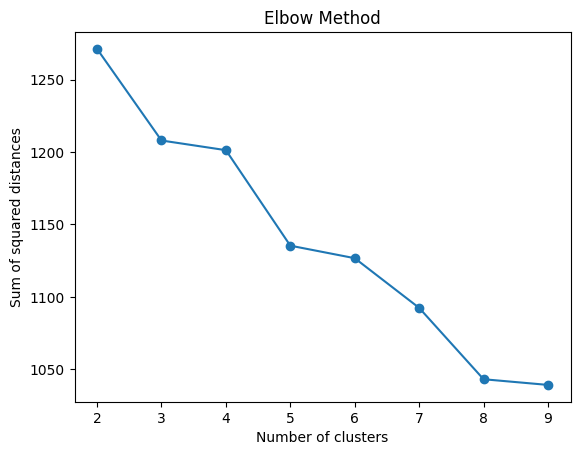

In [64]:
plot_elbow_method(tfidf_matrix)

KeyboardInterrupt: 

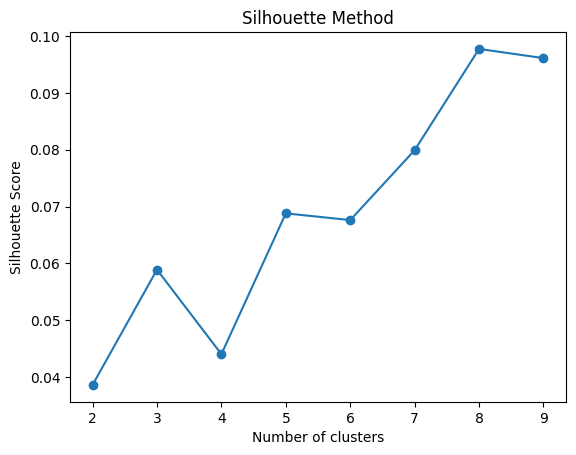

In [65]:
plot_silhouette_method(tfidf_matrix)

In [66]:
num_clusters = 8

In [67]:
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

KMeans(random_state=42)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


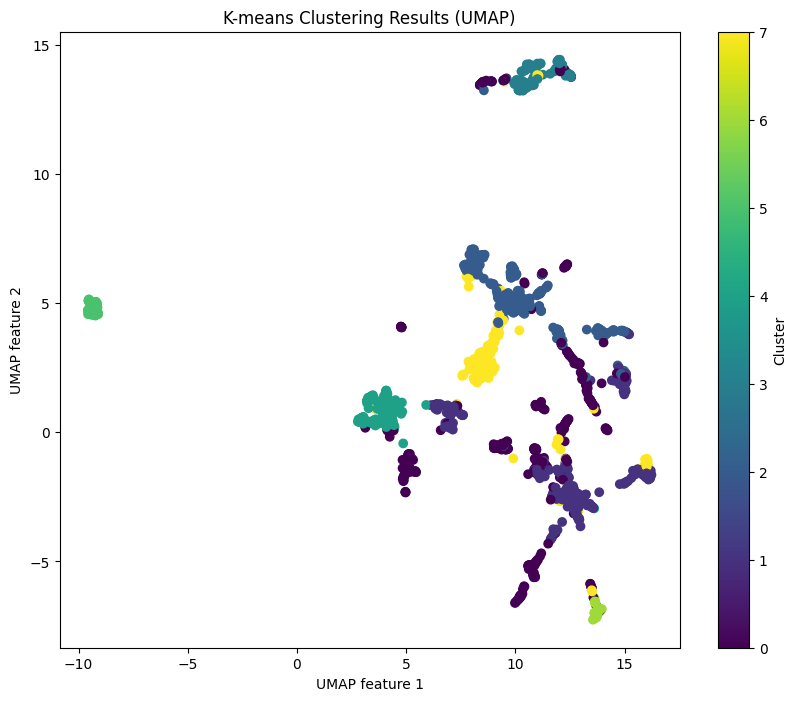

In [68]:
# Reduce dimensionality using UMAP
umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(tfidf_matrix)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('K-means Clustering Results (UMAP)')
plt.xlabel('UMAP feature 1')
plt.ylabel('UMAP feature 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Step 1: Assign Cluster Labels to the Original DataFrame
combined_df1['Cluster'] = kmeans.labels_

# Step 2: Group by Cluster to See ANZSCO Titles in Each Cluster
cluster_titles = combined_df1.groupby('Cluster')['ANZSCO Title'].apply(list)

# Step 3: Print or Analyze the Titles in Each Cluster
for cluster, titles in cluster_titles.items():
    print(f"\nCluster {cluster}:")
    print(", ".join(random.sample(titles, min(5, len(titles)))))


In [69]:
import random

In [70]:
# Step 1: Assign Cluster Labels to the Original DataFrame
combined_df1['Cluster'] = kmeans.labels_

# Step 2: Group by Cluster to See ANZSCO Titles in Each Cluster
cluster_titles = combined_df1.groupby('Cluster')['ANZSCO Title'].apply(list)

# Step 3: Print or Analyze the Titles in Each Cluster
for cluster, titles in cluster_titles.items():
    print(f"\nCluster {cluster}:")
    print(", ".join(random.sample(titles, min(5, len(titles)))))



Cluster 0:
Theatrical Dresser, Funeral Director's Assistant, ICT Sales Assistants, Sales Demonstrator, Vlogger

Cluster 1:
Environmental Consultant, Faculty Head, Contract Administrator, Intelligence Officer, Corporate Treasurer

Cluster 2:
Floor Finishers, Ice-cream Maker, Furniture Finisher, Toolmaker, Sign Erector

Cluster 3:
Deer Farmer, Aquaculture or Fisheries Technician, Pearl Technician, Garden Labourer, Hop Farm Worker

Cluster 4:
Registered Nurse (Surgical), Dental Specialist, Natural Remedy Consultant, Hypnotherapist, Medical Administrator / Medical Superintendent

Cluster 5:
Complementary Health Therapists nec, Information and Organisation Professionals nec, Mobile Plant Operators nec, Judicial and Other Legal Professionals nec, Actors, Dancers and Other Entertainers nec

Cluster 6:
First Aid Trainer, Nurse Educator, Vocational Education Teacher / Polytechnic Teacher, Teacher of English to Speakers of Other Languages, Secondary School Teacher

Cluster 7:
Taxation Economist

In [71]:
combined_0 = combined_df1[combined_df1['Cluster'] == 0]
combined_1 = combined_df1[combined_df1['Cluster'] == 1]
combined_2 = combined_df1[combined_df1['Cluster'] == 2]
combined_3 = combined_df1[combined_df1['Cluster'] == 3]
combined_4 = combined_df1[combined_df1['Cluster'] == 4]
combined_5 = combined_df1[combined_df1['Cluster'] == 5]
combined_6 = combined_df1[combined_df1['Cluster'] == 6]
combined_7 = combined_df1[combined_df1['Cluster'] == 7]

In [72]:
cluster0_token = combined_0["concatenated"].apply(tokenize)
cluster1_token = combined_1["concatenated"].apply(tokenize)
cluster2_token = combined_2["concatenated"].apply(tokenize)
cluster3_token = combined_3["concatenated"].apply(tokenize)
cluster4_token = combined_4["concatenated"].apply(tokenize)
cluster5_token = combined_5["concatenated"].apply(tokenize)
cluster6_token = combined_6["concatenated"].apply(tokenize)
cluster7_token = combined_7["concatenated"].apply(tokenize)

In [73]:
for i in range(8):
    # Get the tokenized data for the current cluster
    tokenized_data = globals().get(f'cluster{i}_token')  # Dynamically access cluster variables

    # Apply function to remove stopwords
    tokenized_data_desc = [remove_stopword(text) for text in tokenized_data]

    # Create the bigrams
    bigram_data_desc = [create_bigrams(text) for text in tokenized_data_desc]

    # Lemmatize the text
    lemmatized_data_desc = [lemmatize(text) for text in bigram_data_desc]

    # Flatten the list of tokens
    flattened_text = [token for sublist in lemmatized_data_desc for token in sublist]

    # Get top trigrams
    top_trigrams = get_top_ngrams(flattened_text, 3, 10)

    # Print the results
    print(f"\nTop 10 Trigrams: Cluster {i}")
    for trigram, count in top_trigrams:
        print(f"{' '.join(trigram)}: {count}")


Top 10 Trigrams: Cluster 0
social medium platform: 100
material resource equipment: 91
monitor maintain inventory: 86
maintain inventory material: 86
inventory material resource: 86
resource equipment product: 86
product good service: 82
collect information customer: 79
information customer client: 79
customer client user: 79

Top 10 Trigrams: Cluster 1
project management software: 212
business intelligence decision: 207
intelligence decision support: 207
decision support software: 207
statistical data analysis: 176
data analysis software: 176
software project management: 154
financial management system: 134
organisational process policy: 133
process policy change: 133

Top 10 Trigrams: Cluster 2
review design blueprint: 178
design blueprint specification: 178
blueprint specification diagram: 178
specification diagram work: 178
diagram work order: 178
work order documentation: 178
order documentation determine: 178
documentation determine work: 178
determine work requirement: 178
prod

In [74]:
# Define the folder containing the CSV files
folder_path = '/content/drive/My Drive/NLP/AT1/ESCO/'  # Adjust the path as necessary

# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Create a dictionary to store DataFrames
dfs = {}

# Loop through each CSV file and load it into a DataFrame
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df_name = file.replace('.csv', '')  # Use the file name (without extension) as the DataFrame key
    dfs[df_name] = pd.read_csv(file_path)

# Print the names, shapes, and the first 5 rows of all loaded DataFrames
for name, df in dfs.items():
    print(f"{name}: {df.shape}")

broaderRelationsOccPillar_en: (3652, 4)
languageSkillsCollection_en: (359, 10)
occupationSkillRelations_en: (129004, 4)
digCompSkillsCollection_en: (25, 10)
digitalSkillsCollection_en: (1284, 10)
conceptSchemes_en: (19, 7)
greenSkillsCollection_en: (591, 10)
broaderRelationsSkillPillar_en: (20822, 4)
occupations_en: (3039, 14)
ISCOGroups_en: (619, 8)
skills_en: (13939, 13)
skillsHierarchy_en: (640, 14)
skillSkillRelations_en: (5818, 5)
skillGroups_en: (640, 11)
transversalSkillsCollection_en: (95, 10)
researchOccupationsCollection_en: (122, 8)
researchSkillsCollection_en: (40, 10)


In [75]:
dfs['skills_en'].skillType.value_counts()

,count
skillType,
skill/competence,10715
knowledge,3219


In [ ]:
dfs

In [98]:
# Load the main skills file from dfs
skills_df = dfs['skills_en']

# Define skill collections and corresponding columns
collections = {
    "languageSkillsCollection_en": "language",
    "digCompSkillsCollection_en": "digital_competence",
    "digitalSkillsCollection_en": "digital_skills",
    "greenSkillsCollection_en": "green_skills",
    "researchSkillsCollection_en": "research",
    "transversalSkillsCollection_en" : "transversal"
}

# Ensure broaderConceptPT column exists in skills_df
if "broaderConceptPT" not in skills_df.columns:
    skills_df["broaderConceptPT"] = ""

# Loop through collections and update columns + broaderConceptPT
for key, column in collections.items():
    collection_df = dfs[key]  # Accessing the DataFrame from dfs

    # Ensure the category column exists in skills_df
    if column not in skills_df.columns:
        skills_df[column] = ""

    # Update type classification based on conceptUri match
    match_mask = skills_df["conceptUri"].isin(collection_df["conceptUri"])
    skills_df.loc[match_mask, column] = column

    # Update broaderConceptPT where conceptUri matches
    broader_concept_map = dict(zip(collection_df["conceptUri"], collection_df["broaderConceptPT"]))
    skills_df.loc[match_mask, "broaderConceptPT"] = skills_df.loc[match_mask, "conceptUri"].map(broader_concept_map)

# Concatenate all category columns into a single "type" column
skills_df["type"] = skills_df[list(collections.values())].apply(lambda x: ", ".join(x[x != ""]), axis=1)

# Drop the original category columns (optional)
skills_df = skills_df.drop(columns=list(collections.values()))


In [99]:
skills_df.sample(5)

,conceptType,conceptUri,skillType,reuseLevel,preferredLabel,altLabels,hiddenLabels,status,modifiedDate,scopeNote,definition,inScheme,description,type,broaderConceptPT
4749,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/5660c82d-b80b...,knowledge,sector-specific,circus vocabulary,participating in music studio recordings\ncirc...,NaN,released,2024-02-09T17:29:09.009Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,The specific terminology related to the circus...,,
624,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/0bc21589-686b...,skill/competence,sector-specific,attach protective attachments to timber piles,fitting pile points\nattach protection to timb...,NaN,released,2016-12-20T18:21:05Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,"Attach various protective elements, such as bo...",,
2534,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/2dd6ecdf-8a08...,skill/competence,sector-specific,carry out sales analysis,carrying out a sales analysis\noversee sales a...,NaN,released,2024-02-09T17:29:10.678Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Examine sales reports to see what goods and se...,,
2210,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/2874065e-6ca3...,knowledge,transversal,Kurdish,ability to comprehend spoken and written Kurdi...,NaN,released,2024-02-09T17:29:10.678Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,The ​Kurdish language.,language,languages | mastering languages
2559,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/2e62b29d-3aa8...,skill/competence,sector-specific,empower social service users,help social service users to gain control over...,NaN,released,2024-02-09T17:29:11.47Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,"Enable individuals, families, groups and commu...",,


In [100]:
merged_df_ESCO = pd.merge(
    dfs['occupationSkillRelations_en'],  # The first DataFrame
    dfs['occupations_en'][['conceptUri', 'preferredLabel']],  # Columns to merge from the second DataFrame
    left_on='occupationUri',  # Column from the first DataFrame
    right_on='conceptUri',  # Column from the second DataFrame
    how='left'  # 'left' join to keep all rows from occupationSkillRelations_en
)

merged_df_ESCO = pd.merge(
    merged_df_ESCO,  # The DataFrame that already has merged occupation and occupations information
    skills_df[['conceptUri', 'conceptType', 'skillType', 'reuseLevel', 'preferredLabel', 'altLabels', 'description', 'type', 'broaderConceptPT']],  # Columns to merge from skills_en
    left_on='skillUri',  # Column from merged_df to match
    right_on='conceptUri',  # Column from skills_en to match
    how='left'  # Left join to keep all rows from merged_df
)

# Display the first few rows of the merged DataFrame
merged_df_ESCO.sample(5)

,occupationUri,relationType,skillType_x,skillUri,conceptUri_x,preferredLabel_x,conceptUri_y,conceptType,skillType_y,reuseLevel,preferredLabel_y,altLabels,description,type,broaderConceptPT
94296,http://data.europa.eu/esco/occupation/b558a934...,optional,skill/competence,http://data.europa.eu/esco/skill/6be072f1-e340...,http://data.europa.eu/esco/occupation/b558a934...,membranophone musical instruments maker,http://data.europa.eu/esco/skill/6be072f1-e340...,KnowledgeSkillCompetence,skill/competence,sector-specific,design musical instruments,designing a musical instrument\narrange musica...,Develop and design a musical instrument accord...,,
106468,http://data.europa.eu/esco/occupation/cb4f98c8...,essential,skill/competence,http://data.europa.eu/esco/skill/1368c06f-202d...,http://data.europa.eu/esco/occupation/cb4f98c8...,public procurement specialist,http://data.europa.eu/esco/skill/1368c06f-202d...,KnowledgeSkillCompetence,skill/competence,cross-sector,perform contract reporting and evaluation,contract monitoring and evaluation\ncarry out ...,Perform ex-post assessment of the deliverables...,,
110839,http://data.europa.eu/esco/occupation/d5a43cd3...,optional,skill/competence,http://data.europa.eu/esco/skill/56a10e3e-c9e7...,http://data.europa.eu/esco/occupation/d5a43cd3...,digital media designer,http://data.europa.eu/esco/skill/56a10e3e-c9e7...,KnowledgeSkillCompetence,skill/competence,cross-sector,use content management system software,apply content management system software\nhand...,"Use software that allows publishing, editing a...",digital_skills,"managing, gathering and storing digital data"
59733,http://data.europa.eu/esco/occupation/72913ee1...,optional,knowledge,http://data.europa.eu/esco/skill/eaa4cdc0-43e0...,http://data.europa.eu/esco/occupation/72913ee1...,emergency response coordinator,http://data.europa.eu/esco/skill/eaa4cdc0-43e0...,KnowledgeSkillCompetence,knowledge,sector-specific,first response,first responder\nfirst aid care\nfirst aid\nre...,The procedures of pre-hospital care for medica...,,
47233,http://data.europa.eu/esco/occupation/5a2d0031...,essential,skill/competence,http://data.europa.eu/esco/skill/293301db-be3c...,http://data.europa.eu/esco/occupation/5a2d0031...,wholesale merchant in dairy products and edibl...,http://data.europa.eu/esco/skill/293301db-be3c...,KnowledgeSkillCompetence,skill/competence,cross-sector,monitor international market performance,implement international market performance\nmo...,Continuously monitor the international market ...,,


In [102]:
concat_ESCO = concatenate_by_group_same_row(merged_df_ESCO, 'preferredLabel_x', ['description'])

In [103]:
concat_ESCO.head(5)

,preferredLabel_x,concatenated
0,artificial intelligence engineer,"Identify, locate, retrieve, store, organise an..."
1,3D animator,"The field of particle animation, an animation ..."
2,3D modeller,The process of applying a type of surface to a...
3,3D printing technician,The process of reproducing 3D objects by using...
4,ATM repair technician,"Various type of machines and tools, including ..."


In [104]:
tokenized_data = concat_ESCO["concatenated"].apply(tokenize)
tokenized_data_desc = [remove_stopword(text) for text in tokenized_data]
bigram_data_desc = [create_bigrams(text) for text in tokenized_data_desc]
lemmatized_data_desc = [lemmatize(text) for text in bigram_data_desc]
flattened_text = [token for sublist in lemmatized_data_desc for token in sublist]
top_trigrams = get_top_ngrams(flattened_text, 3, 10)

print(f"\nTop 10 Trigrams: Cluster {i}")
for trigram, count in top_trigrams:
  print(f"{' '.join(trigram)}: {count}")


Top 10 Trigrams: Cluster 7
technique principle software: 1735
principle software development: 1735
software development analysis: 1735
development analysis algorithm: 1735
analysis algorithm code: 1735
algorithm code test: 1731
code test compile: 1731
test compile programming: 1731
compile programming paradigms: 1013
compile programming paradigm: 720


In [105]:
# Create a dictionary
dictionary = Dictionary(lemmatized_data_desc)
dictionary.filter_extremes(no_above=0.9)
corpus = [dictionary.doc2bow(text) for text in lemmatized_data_desc]
lda_model = LdaModel(
   corpus=corpus, id2word=dictionary, num_topics=10,
   random_state=100, update_every=1, chunksize=100,
   passes=10, alpha=0.01, eta=0.01, per_word_topics=True
)
lda_model.save("lda_model")
del lda_model
lda_model = LdaModel.load("lda_model")

# Enable the display of visualizations in IPython Notebooks
pyLDAvis.enable_notebook()

# Prepare and transform and LDA model
pyLDAvis_data = prepare(lda_model, corpus, dictionary)
pyLDAvis.display(pyLDAvis_data)

In [107]:
vectorizer = TfidfVectorizer(stop_words='english')  # You can tweak the stop_words as needed
tfidf_matrix = vectorizer.fit_transform(concat_ESCO["concatenated"].dropna())

# Compute the cosine similarity matrix
cos_sim_matrix = cosine_similarity(tfidf_matrix)

# Define a threshold for similarity
threshold = 0.8

# Get the indices of the highly similar pairs
similar_pairs = np.where(cos_sim_matrix > threshold)

# Create a dictionary to store the count of high similarity and similar titles for each 'ANZSCO Title'
similarity_count = {}
similar_titles = {}

# Loop through the pairs and count the similarities
for i, j in zip(*similar_pairs):
    if i != j:  # Avoid comparing the row with itself
        title_i = concat_ESCO['preferredLabel_x'].iloc[i]
        title_j = concat_ESCO['preferredLabel_x'].iloc[j]

        # Update the count for each ANZSCO Title pair
        similarity_count[title_i] = similarity_count.get(title_i, 0) + 1
        similarity_count[title_j] = similarity_count.get(title_j, 0) + 1

        # Track the similar titles for each 'ANZSCO Title'
        if title_i not in similar_titles:
            similar_titles[title_i] = []
        if title_j not in similar_titles:
            similar_titles[title_j] = []

        similar_titles[title_i].append(title_j)
        similar_titles[title_j].append(title_i)

# Sort the titles based on the number of similarities (highest first)
sorted_titles = sorted(similarity_count.items(), key=lambda x: x[1], reverse=True)

# Set to keep track of processed titles to avoid repeating them
processed_titles = set()
title_isolated = []

# Print the top titles with high similarity, ensuring no repeats
print("Top ESCO titles with high similarity:")

for title, count in sorted_titles:
    if title in processed_titles:
        continue  # Skip if this title has already been processed

    # Print the title and its similarity count
    print(f"\nTitle: {title} - Similarity Count: {count/2}")
    title_isolated.append(title)

    # Get the similar titles, removing duplicates using a set
    similar_titles_set = set(similar_titles[title])

    # Print all similar titles for the current title
    print(f"Similar Titles: {', '.join(similar_titles_set)}")

    # Add this title and its similar titles to the processed set to avoid repeating them
    processed_titles.add(title)
    processed_titles.update(similar_titles_set)

Top ESCO titles with high similarity:

Title: ICT technician - Similarity Count: 44.0
Similar Titles: user interface developer, ICT network administrator, digital games developer, webmaster, telecommunications engineer, computer science lecturer, computer hardware engineer, computer hardware engineering technician, database developer, industrial mobile devices software developer, knowledge engineer, integration engineer, telecommunications engineering technician, application engineer, digital media designer, ICT application developer, software tester, web developer, ICT network engineer, ICT security technician, embedded systems software developer, software developer, chief technology officer, data warehouse designer, embedded system designer, software analyst, ICT system developer, user interface designer, 3D modeller, ICT system analyst, mobile application developer, system configurator, mobile devices technician, enterprise architect, ICT application configurator, database designer,

In [81]:
merged_df_ESCO = merged_df_ESCO.replace("\n", " ", regex=True)

In [82]:
merged_df_ESCO.head(5)

,occupationUri,relationType,skillType_x,skillUri,conceptUri_x,preferredLabel_x,conceptUri_y,conceptType,skillType_y,reuseLevel,preferredLabel_y,altLabels,description
0,http://data.europa.eu/esco/occupation/00030d09...,essential,knowledge,http://data.europa.eu/esco/skill/fed5b267-73fa...,http://data.europa.eu/esco/occupation/00030d09...,technical director,http://data.europa.eu/esco/skill/fed5b267-73fa...,KnowledgeSkillCompetence,knowledge,sector-specific,theatre techniques,theatre technique theatre approaches theatre m...,The techniques that facilitate a successful pr...
1,http://data.europa.eu/esco/occupation/00030d09...,essential,skill/competence,http://data.europa.eu/esco/skill/05bc7677-5a64...,http://data.europa.eu/esco/occupation/00030d09...,technical director,http://data.europa.eu/esco/skill/05bc7677-5a64...,KnowledgeSkillCompetence,skill/competence,sector-specific,organise rehearsals,organise rehearsal organize rehearsals plan re...,"Manage, schedule and run rehearsals for the pe..."
2,http://data.europa.eu/esco/occupation/00030d09...,essential,skill/competence,http://data.europa.eu/esco/skill/271a36a0-bc7a...,http://data.europa.eu/esco/occupation/00030d09...,technical director,http://data.europa.eu/esco/skill/271a36a0-bc7a...,KnowledgeSkillCompetence,skill/competence,sector-specific,write risk assessment on performing arts produ...,write assessment of risks about performing art...,"Assess risks, propose improvements and describ..."
3,http://data.europa.eu/esco/occupation/00030d09...,essential,skill/competence,http://data.europa.eu/esco/skill/47ed1d37-971b...,http://data.europa.eu/esco/occupation/00030d09...,technical director,http://data.europa.eu/esco/skill/47ed1d37-971b...,KnowledgeSkillCompetence,skill/competence,sector-specific,coordinate with creative departments,liaise with other artistic departments coordin...,Coordinate activities with other artistic and ...
4,http://data.europa.eu/esco/occupation/00030d09...,essential,skill/competence,http://data.europa.eu/esco/skill/591dd514-735b...,http://data.europa.eu/esco/occupation/00030d09...,technical director,http://data.europa.eu/esco/skill/591dd514-735b...,KnowledgeSkillCompetence,skill/competence,sector-specific,adapt to artists' creative demands,meet demands by creative artists adapt to dema...,"Work with artists, striving to understand the ..."


In [77]:
dfs['occupations_en'].head(5)

,conceptType,conceptUri,iscoGroup,preferredLabel,altLabels,hiddenLabels,status,modifiedDate,regulatedProfessionNote,scopeNote,definition,inScheme,description,code
0,Occupation,http://data.europa.eu/esco/occupation/00030d09...,2654,technical director,technical and operations director\nhead of tec...,NaN,released,2024-01-25T11:28:50.295Z,http://data.europa.eu/esco/regulated-professio...,NaN,NaN,http://data.europa.eu/esco/concept-scheme/occu...,Technical directors realise the artistic visio...,2654.1.7
1,Occupation,http://data.europa.eu/esco/occupation/000e93a3...,8121,metal drawing machine operator,metal drawing machine technician\nmetal drawin...,NaN,released,2024-01-23T10:09:32.099Z,http://data.europa.eu/esco/regulated-professio...,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Metal drawing machine operators set up and ope...,8121.4
2,Occupation,http://data.europa.eu/esco/occupation/0019b951...,7543,precision device inspector,inspector of precision instruments\nprecision ...,NaN,released,2024-01-25T15:00:12.188Z,http://data.europa.eu/esco/regulated-professio...,NaN,NaN,http://data.europa.eu/esco/concept-scheme/occu...,Precision device inspectors make sure precisio...,7543.10.3
3,Occupation,http://data.europa.eu/esco/occupation/0022f466...,3155,air traffic safety technician,air traffic safety electronics hardware specia...,NaN,released,2024-01-29T16:01:13.998Z,http://data.europa.eu/esco/regulated-professio...,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Air traffic safety technicians provide technic...,3155.1
4,Occupation,http://data.europa.eu/esco/occupation/002da35b...,2431,hospitality revenue manager,hospitality revenues manager\nyield manager\nh...,NaN,released,2024-01-11T10:28:45.871Z,http://data.europa.eu/esco/regulated-professio...,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Hospitality revenue managers maximise revenue ...,2431.9


In [108]:
dfs['occupations_en'] = dfs['occupations_en'].replace("\n", " ", regex=True)

In [109]:
vectorizer = TfidfVectorizer(stop_words='english')  # You can tweak the stop_words as needed
tfidf_matrix = vectorizer.fit_transform(dfs['occupations_en']["description"].dropna())

# Compute the cosine similarity matrix
cos_sim_matrix = cosine_similarity(tfidf_matrix)

# Define a threshold for similarity
threshold = 0.8

# Get the indices of the highly similar pairs
similar_pairs = np.where(cos_sim_matrix > threshold)

# Create a dictionary to store the count of high similarity and similar titles for each 'ANZSCO Title'
similarity_count = {}
similar_titles = {}

# Loop through the pairs and count the similarities
for i, j in zip(*similar_pairs):
    if i != j:  # Avoid comparing the row with itself
        title_i = dfs['occupations_en']['preferredLabel'].iloc[i]
        title_j = dfs['occupations_en']['preferredLabel'].iloc[j]

        # Update the count for each ANZSCO Title pair
        similarity_count[title_i] = similarity_count.get(title_i, 0) + 1
        similarity_count[title_j] = similarity_count.get(title_j, 0) + 1

        # Track the similar titles for each 'ANZSCO Title'
        if title_i not in similar_titles:
            similar_titles[title_i] = []
        if title_j not in similar_titles:
            similar_titles[title_j] = []

        similar_titles[title_i].append(title_j)
        similar_titles[title_j].append(title_i)

# Sort the titles based on the number of similarities (highest first)
sorted_titles = sorted(similarity_count.items(), key=lambda x: x[1], reverse=True)

# Set to keep track of processed titles to avoid repeating them
processed_titles = set()
title_isolated = []

# Print the top titles with high similarity, ensuring no repeats
print("Top ESCO titles with high similarity:")

for title, count in sorted_titles:
    if title in processed_titles:
        continue  # Skip if this title has already been processed

    # Print the title and its similarity count
    print(f"\nTitle: {title} - Similarity Count: {count/2}")
    title_isolated.append(title)

    # Get the similar titles, removing duplicates using a set
    similar_titles_set = set(similar_titles[title])

    # Print all similar titles for the current title
    print(f"Similar Titles: {', '.join(similar_titles_set)}")

    # Add this title and its similar titles to the processed set to avoid repeating them
    processed_titles.add(title)
    processed_titles.update(similar_titles_set)

Top ESCO titles with high similarity:

Title: wholesale merchant - Similarity Count: 34.0
Similar Titles: wholesale merchant in hides, skins and leather products, wholesale merchant in electrical household appliances, wholesale merchant in hardware, plumbing and heating equipment and supplies, wholesale merchant in machinery, industrial equipment, ships and aircraft, wholesale merchant in clothing and footwear, wholesale merchant in chemical products, wholesale merchant in pharmaceutical goods, wholesale merchant in tobacco products, wholesale merchant in watches and jewellery, wholesale merchant in flowers and plants, wholesale merchant in beverages, wholesale merchant in office furniture, wholesale merchant in metals and metal ores, wholesale merchant in live animals, wholesale merchant in perfume and cosmetics, wholesale merchant in textile industry machinery, wholesale merchant in mining, construction and civil engineering machinery, wholesale merchant in waste and scrap, wholesale

In [112]:
ESCO_doc = pd.merge(
    dfs['occupations_en'],
    concat_ESCO[['preferredLabel_x', 'concatenated']],
    left_on='preferredLabel',
    right_on='preferredLabel_x',
    how='right'
)

ESCO_clean = concatenate_by_group_same_row(ESCO_doc, 'preferredLabel_x', ['description', 'concatenated'])
vectorizer = TfidfVectorizer(stop_words='english')  # You can tweak the stop_words as needed
tfidf_matrix = vectorizer.fit_transform(ESCO_clean['concatenated'].dropna())

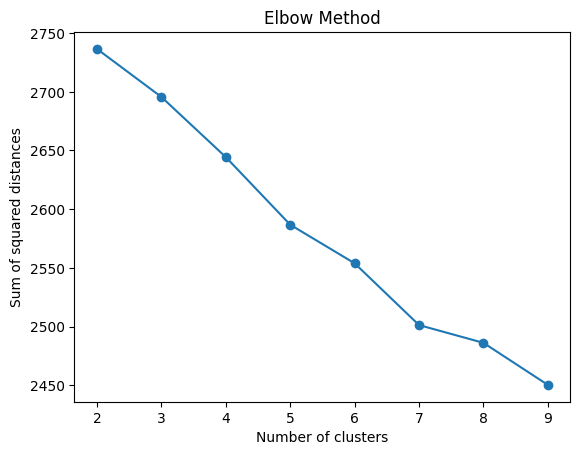

In [115]:
plot_elbow_method(tfidf_matrix)

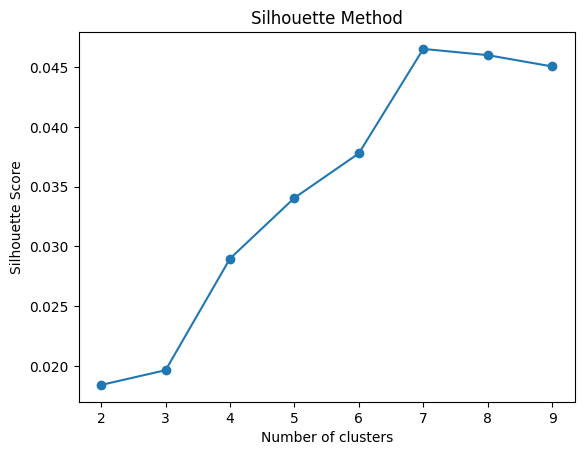

In [116]:
plot_silhouette_method(tfidf_matrix)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


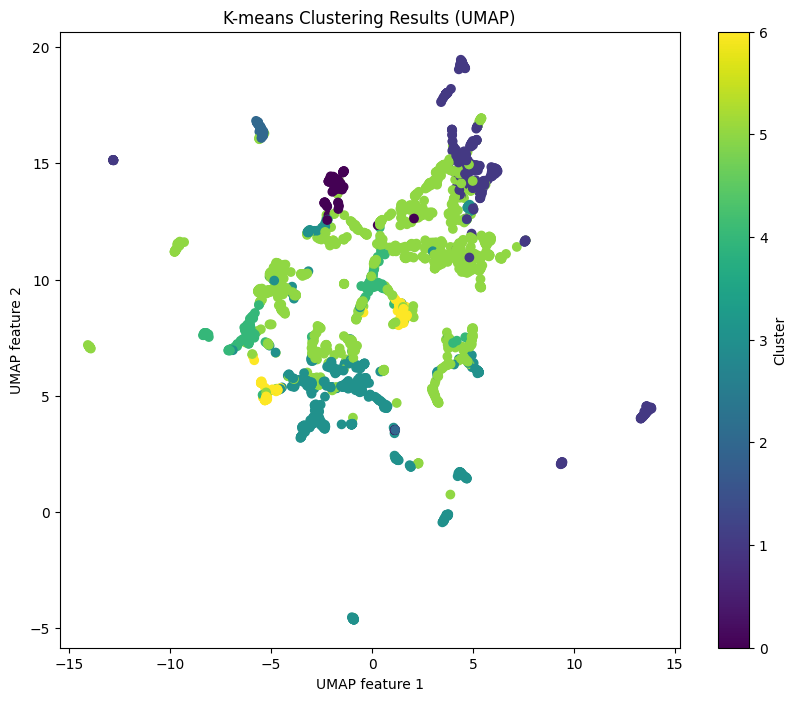

In [117]:
num_clusters = 7

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Reduce dimensionality using UMAP
umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(tfidf_matrix)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('K-means Clustering Results (UMAP)')
plt.xlabel('UMAP feature 1')
plt.ylabel('UMAP feature 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [119]:
ESCO_clean.head(5)

,preferredLabel_x,concatenated
0,artificial intelligence engineer,Artificial intelligence engineer apply methods...
1,3D animator,3D animators are in charge of animating 3D mod...
2,3D modeller,"3D modellers design 3D models of objects, virt..."
3,3D printing technician,3D printing technicians assist in the designin...
4,ATM repair technician,"ATM repair technicians install, diagnose, main..."


In [120]:
# Step 1: Assign Cluster Labels to the Original DataFrame
ESCO_clean['Cluster'] = kmeans.labels_

# Step 2: Group by Cluster to See ANZSCO Titles in Each Cluster
cluster_titles = ESCO_clean.groupby('Cluster')['preferredLabel_x'].apply(list)

# Step 3: Print or Analyze the Titles in Each Cluster
for cluster, titles in cluster_titles.items():
    print(f"\nCluster {cluster}:")
    print(", ".join(random.sample(titles, min(5, len(titles)))))


Cluster 0:
blanching operator, wine sommelier, prepared meals nutritionist, clarifier, food and beverage packaging technologist

Cluster 1:
froth flotation deinking operator, leather goods finishing operator, metal furnace operator, embroidery machine operator, lasting machine operator

Cluster 2:
animal behaviourist, animal massage therapist, live animal transporter, taxidermist, animal embryo transfer technician

Cluster 3:
housing policy officer, marketing assistant, pet and pet food specialised seller, call centre quality auditor, rental service representative in personal and household goods

Cluster 4:
environmental scientist, electronics and automation vocational teacher, visual arts teacher, assistive technologist, seismologist

Cluster 5:
nanoengineer, advertising installer, motor vehicle assembly inspector, database designer, translator

Cluster 6:
nuclear medicine radiographer, volunteer mentor, employment support worker, youth programme director, hospital social worker


In [121]:
# Define a list of clusters
clusters = range(7)  # Assuming clusters are from 0 to 7

# Loop through each cluster
for cluster in clusters:
    # Create a new column for each cluster's tokenized data
    cluster_name = f"ESCO_{cluster}_token"
    ESCO_clean_cluster = ESCO_clean[ESCO_clean['Cluster'] == cluster]

    # Apply the tokenize function to the 'concatenated' column
    globals()[cluster_name] = ESCO_clean_cluster["concatenated"].apply(tokenize)

In [125]:
clusters = range(7)

for cluster in clusters:
    # Get the tokenized data for the current cluster
    tokenized_data = globals().get(f'ESCO_{cluster}_token')  # Dynamically access cluster variables

    # Apply function to remove stopwords
    tokenized_data_desc = [remove_stopword(text) for text in tokenized_data]

    # Create the bigrams
    bigram_data_desc = [create_bigrams(text) for text in tokenized_data_desc]

    # Lemmatize the text
    lemmatized_data_desc = [lemmatize(text) for text in bigram_data_desc]

    # Flatten the list of tokens
    flattened_text = [token for sublist in lemmatized_data_desc for token in sublist]

    # Get top trigrams
    top_trigrams = get_top_ngrams(flattened_text, 3, 10)

    # Print the results
    print(f"\nTop 10 Trigrams: Cluster {cluster}")
    for trigram, count in top_trigrams:
        print(f"{' '.join(trigram)}: {count}")


Top 10 Trigrams: Cluster 0
food safety procedure: 213
food food safety: 205
apply regulation regard: 204
regulation regard manufacture: 204
regard manufacture food: 204
manufacture food food: 204
food safety compliance: 204
safety compliance employ: 204
compliance employ food: 204
employ food safety: 204

Top 10 Trigrams: Cluster 1
machine machine tool: 329
footwear leather good: 226
monitor operate accord: 170
operate accord regulation: 170
product service process: 161
international requirement specification: 160
requirement specification guideline: 160
specification guideline ensure: 160
guideline ensure product: 160
ensure product service: 160

Top 10 Trigrams: Cluster 2
transmission disease ensure: 75
plan use appropriate: 73
measure prevent transmission: 73
prevent transmission disease: 73
disease ensure effective: 73
ensure effective overall: 73
communicate site hygiene: 73
site hygiene control: 73
work animal include: 62
animal welfare need: 54

Top 10 Trigrams: Cluster 3
legal